<a href="https://colab.research.google.com/github/gaws15/AINotebooksVault/blob/main/paper_2_deepl_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

01_F-RCNN

In [ ]:
# Install required libraries
!pip install thop pycocotools
!apt-get install -y nvidia-driver-460 nvidia-utils-460
import os
os.environ['LD_LIBRARY_PATH'] = '/usr/lib/nvidia-460-server:' + os.environ.get('LD_LIBRARY_PATH', '')

import json
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.patches as patches
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
# import pynvml # Make sure pynvml is imported
from thop import profile
from torch.cuda.amp import GradScaler, autocast

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
base_dir = '/content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s'
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
valid_dir = os.path.join(base_dir, "valid")
model_save_path = os.path.join(base_dir, "efficient_detr_model.pth")

# Initialize NVML - Removed due to potential issues
# try:
#     pynvml.nvmlInit()
# except Exception as e:
#     print(f"NVML initialization failed: {e}. Skipping GPU memory reporting.")
#     gpu_memory = 0.0


from google.colab import drive
drive.mount('/content/drive')

# ==============================================
# Step 1: Custom Dataset for COCO Annotations (Object Detection) COCO Formatında Veri Seti Sınıfı
# ==============================================
class COCODataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        json_path = os.path.join(directory, "_annotations.coco.json")
        with open(json_path, 'r') as f:
            annotations = json.load(f)

        self.images = {img["id"]: img["file_name"] for img in annotations["images"]}
        self.categories = {cat["id"]: cat["name"] for cat in annotations["categories"]}
        self.annotations = annotations["annotations"]
        self.class_names = sorted(list(self.categories.values()))
        self.label_to_idx = {name: idx + 1 for idx, name in enumerate(self.class_names)}

        self.image_annotations = {}
        for ann in self.annotations:
            image_id = ann["image_id"]
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
            self.image_annotations[image_id].append(ann)

        self.image_ids = list(self.image_annotations.keys())
        print(f"Loaded {len(self.image_ids)} images from {directory}")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.directory, self.images[image_id])
        image = Image.open(image_path).convert("RGB")

        annotations = self.image_annotations.get(image_id, [])
        boxes = []
        labels = []
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            boxes.append([x, y, x + w, y + h])
            labels.append(self.label_to_idx[self.categories[ann["category_id"]]])

        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([image_id])}
        return image, target
"""
Bu sınıf, COCO formatındaki veri setini yükler. Her görüntü için etiketler (bounding box'lar ve sınıf etiketleri) döndürür.
__getitem__ metodu, görüntüyü ve hedef etiketleri (bounding box'lar ve sınıf etiketleri) döndürür.
"""

# Transformations / Veri Dönüşümleri ve DataLoader
transform = transforms.Compose([transforms.ToTensor()])

# Load datasets
train_dataset = COCODataset(train_dir, transform=transform)
valid_dataset = COCODataset(valid_dir, transform=transform)
test_dataset = COCODataset(test_dir, transform=transform)


# DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# Reduced batch size for efficiency
batch_size = 8
print(f"Using batch size: {batch_size}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)  # Smaller batch for efficiency
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

class_names = train_dataset.class_names
num_classes = len(class_names) + 1  # +1 for background
print("#class: ",num_classes)
"""
Görüntüler ToTensor() ile tensörlere dönüştürülür.
DataLoader, veri setini batch'ler halinde yükler. collate_fn, batch'leri düzgün bir şekilde paketler."""

# ==============================================
# Step 2: Define and Load/Save the Faster R-CNN Model
# ==============================================
def create_fasterrcnn_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model.to(device)


fasterrcnn_model = create_fasterrcnn_model(num_classes)
optimizer = optim.Adam(fasterrcnn_model.parameters(), lr=5e-5)
scaler = GradScaler() # For mixed precision training

""" Faster R-CNN modeli, önceden eğitilmiş bir model (fasterrcnn_resnet50_fpn) kullanılarak oluşturulur.
Modelin sınıf sayısı, veri setindeki sınıf sayısına göre ayarlanır."""

# if os.path.exists(model_save_path):
#     fasterrcnn_model.load_state_dict(torch.load(model_save_path, map_location=device))
#     print(f"Loaded model from {model_save_path}")

# ==============================================
# Step 3: Visualize the Dataset
# ==============================================
def imshow(img, boxes=None, labels=None, class_names=None, title=None):
    img = img.cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    if boxes is not None and labels is not None and class_names is not None:
        ax = plt.gca()
        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = box
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r',
                                     facecolor='none')
            ax.add_patch(rect)
            ax.text(x_min, y_min, class_names[label - 1], bbox=dict(facecolor='red', alpha=0.5))
    if title:
        plt.title(title)
    plt.axis("off")


plt.figure(figsize=(10, 5))
images, targets = next(iter(train_loader))
for i in range(min(2, len(images))):
    plt.subplot(1, 2, i + 1)
    imshow(images[i], targets[i]["boxes"], targets[i]["labels"], class_names)
plt.tight_layout()
plt.show()
""" bu Veri setindeki görüntüler ve bounding box'lar görselleştirilir.
 veri setinin doğru yüklendiğini kontrol etmek için kullanılır.
"""
# ==============================================
# Step 4: Train the Model
# ==============================================
def train_model(model, train_loader, valid_loader, optimizer, num_epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'val_mAP': [], 'train_acc': [], 'val_acc': []}
    iou_threshold = 0.5

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]")
        for images, targets in train_bar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            optimizer.zero_grad()
            with autocast(): # Mixed precision training
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            scaler.scale(losses).backward() # Scale the loss and backpropagate
            scaler.step(optimizer) # Update optimizer with scaled gradients
            scaler.update() # Update the scaler for the next iteration

            running_loss += losses.item()
            train_bar.set_postfix(loss=losses.item())

            # Compute training accuracy
            model.eval()
            with torch.no_grad():
                preds = model(images)
            model.train()
            for p, t in zip(preds, targets):
                pred_boxes = p["boxes"][p["scores"] > 0.5]
                pred_labels = p["labels"][p["scores"] > 0.5]
                gt_boxes = t["boxes"]
                gt_labels = t["labels"]
                train_total += len(gt_boxes)
                matched = torch.zeros(len(gt_boxes), dtype=torch.bool, device=device)
                for pb, pl in zip(pred_boxes, pred_labels):
                    for i, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
                        if matched[i] or pl != gl:
                            continue
                        iou = calculate_iou(pb.cpu().numpy(), gb.cpu().numpy())
                        if iou >= iou_threshold:
                            train_correct += 1
                            matched[i] = True

        train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation loop
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_preds, val_targets = [], []
        with torch.no_grad(), autocast(): # Mixed precision for validation
            for images, targets in valid_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Compute loss
                model.train()
                loss_dict = model(images, targets)
                val_loss += sum(loss for loss in loss_dict.values()).item()
                model.eval()

                # Compute predictions
                preds = model(images)
                for p, t in zip(preds, targets):  # Pair predictions with targets directly
                    mask = p["scores"] > 0.05
                    filtered_preds = {
                        "boxes": p["boxes"][mask],
                        "labels": p["labels"][mask],
                        "scores": p["scores"][mask]
                    }
                    val_preds.append(filtered_preds)
                    val_targets.append(t)

                    # Compute validation accuracy
                    pred_boxes = filtered_preds["boxes"]
                    pred_labels = filtered_preds["labels"]
                    gt_boxes = t["boxes"]
                    gt_labels = t["labels"]
                    val_total += len(gt_boxes)
                    matched = torch.zeros(len(gt_boxes), dtype=torch.bool, device=device)
                    for pb, pl in zip(pred_boxes, pred_labels):
                        for i, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
                            if matched[i] or pl != gl:
                                continue
                        iou = calculate_iou(pb.cpu().numpy(), gb.cpu().numpy())
                        if iou >= iou_threshold:
                            val_correct += 1
                            matched[i] = True

        val_loss = val_loss / len(valid_loader)
        val_acc = val_correct / val_total if val_total > 0 else 0
        val_mAP = compute_coco_mAP(val_preds, val_targets, os.path.join(valid_dir, "_annotations.coco.json"))
        history['val_loss'].append(val_loss)
        history['val_mAP'].append(val_mAP)
        history['val_acc'].append(val_acc)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val mAP: {val_mAP:.4f}"
        )

    torch.save(model.state_dict(), model_save_path)
    return history
"""
Model, train_loader üzerinde eğitilir. Her epoch'ta eğitim ve doğrulama kaybı hesaplanır.
Doğrulama seti üzerinde mAP (mean Average Precision) hesaplanır.
Model, eğitim sonrası kaydedilir."""

# ==============================================
# Step 5: Evaluate the Model
# ==============================================
def compute_coco_mAP(preds, targets, anno_file):
    coco_gt = COCO(anno_file)
    anns = [{
        "image_id": int(t["image_id"][0].item()),
        "category_id": int(p["labels"][i].item()),
        "bbox": [p["boxes"][i][0].item(), p["boxes"][i][1].item(),
                 p["boxes"][i][2].item() - p["boxes"][i][0].item(),
                 p["boxes"][i][3].item() - p["boxes"][i][1].item()],
        "score": p["scores"][i].item()
    } for p, t in zip(preds, targets) for i in range(len(p["boxes"])) if len(p["boxes"]) > 0]

    if not anns:
        print("Warning: No valid detections found for mAP computation.")
        return 0.0

    coco_dt = coco_gt.loadRes(anns)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats[0]


def evaluate_model(model, test_loader, anno_file):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad(), autocast(): # Mixed precision for evaluation
        for images, targets in tqdm(test_loader, desc="Evaluation"):
            images = list(image.to(device) for image in images)
            preds = model(images)
            filtered_preds = []
            for p in preds:
                mask = p["scores"] > 0.05
                filtered_preds.append({
                    "boxes": p["boxes"][mask],
                    "labels": p["labels"][mask],
                    "scores": p["scores"][mask]
                })
            all_preds.extend(filtered_preds)
            all_targets.extend(targets)
    mAP = compute_coco_mAP(all_preds, all_targets, anno_file)
    print(f"Test mAP: {mAP:.4f}")
    return all_preds, all_targets, mAP

"""Test seti üzerinde modelin performansı değerlendirilir. mAP hesaplanır."""

# ==============================================
# Step 6: Perform Inference on New Images
# ==============================================
def classify_image(model, image_path, class_names, score_threshold=0.5):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    start_time = time.time()
    with torch.no_grad(), autocast(): # Mixed precision for inference
        preds = model(img_tensor)[0]
    latency = (time.time() - start_time) * 1000

    boxes = preds["boxes"].cpu().numpy()
    labels = preds["labels"].cpu().numpy()
    scores = preds["scores"].cpu().numpy()
    mask = scores > score_threshold
    boxes, labels, scores = boxes[mask], labels[mask], scores[mask]

    plt.figure(figsize=(8, 8))
    imshow(img_tensor[0], boxes, labels, class_names)
    plt.show()

    detected_classes = [class_names[label - 1] for label in labels]
    print(f"Detected classes: {detected_classes}, Latency: {latency:.2f} ms")
    return detected_classes, latency

"""Yeni bir görüntü üzerinde modelin çıkarım yapması sağlanır."
   Bounding box'lar ve sınıf etiketleri görselleştirilir.)"""

   # ==============================================
# Step 7: Training History Plot
# ==============================================
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.plot(epochs, history['val_mAP'], 'go-', label='Validation mAP')
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

"Eğitim ve doğrulama kaybı ile mAP değerleri grafik olarak gösterilir."

# ==============================================
# Step 8: Report Metrics
# ==============================================
def report_metrics(model, test_loader, image_path):
    _, latency = classify_image(model, image_path, class_names)
    fps = 1000 / latency
    try:
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        gpu_memory = mem_info.used / 1024 ** 2
    except: # Handle NVML not initialized
        gpu_memory = "N/A"
        print("Could not retrieve GPU memory usage.")

    model.eval()
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    with autocast(): # Mixed precision for profiling
        macs, _ = profile(model, inputs=(dummy_input,))
    flops = macs / 1e9
    _, _, mAP = evaluate_model(model, test_loader, os.path.join(test_dir, "_annotations.coco.json"))

    print(
        f"Average Latency: {latency:.2f} ms, FPS: {fps:.2f}, GPU Memory: {gpu_memory:.2f} MB" if isinstance(gpu_memory, float) else f"Average Latency: {latency:.2f} ms, FPS: {fps:.2f}, GPU Memory: {gpu_memory}",
        f"FLOPs: {flops:.2f} GFLOPs, mAP: {mAP:.4f}")

"""" Modelin performans metrikleri (latency, FPS, GPU memory, FLOPs, mAP) raporlanır.
"""
# ==============================================
# Step 9: Class-wise Precision-Recall (PR) Curves
# ==============================================
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_t, y1_t, x2_t, y2_t = box2
    xi1, yi1 = max(x1, x1_t), max(y1, y1_t)
    xi2, yi2 = min(x2, x2_t), min(y2, y2_t)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_t - x1_t) * (y2_t - y1_t)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

""" IoU, iki bounding box'un kesişim alanının birleşim alanına oranıdır. Bu, modelin tahmin ettiği bounding box ile gerçek bounding box arasındaki örtüşmeyi ölçer.
Bu fonksiyon, iki bounding box arasındaki IoU değerini hesaplar."""

def plot_pr_curves(preds, targets, class_names):
    plt.figure(figsize=(12, 8))
    iou_threshold = 0.5

    for cls_idx, cls_name in enumerate(class_names, 1):
        y_true, y_scores = [], []

        for p, t in zip(preds, targets):
            true_boxes = t["boxes"].cpu().numpy()
            true_labels = t["labels"].cpu().numpy()
            pred_boxes = p["boxes"].cpu().numpy()  # Fixed typo: cpuBROKEN -> cpu()
            pred_labels = p["labels"].cpu().numpy()
            pred_scores = p["scores"].cpu().numpy()

            gt_mask = true_labels == cls_idx
            gt_boxes = true_boxes[gt_mask]
            num_gt = len(gt_boxes)

            pred_mask = pred_labels == cls_idx
            pred_boxes_cls = pred_boxes[pred_mask]
            pred_scores_cls = pred_scores[pred_mask]

            if num_gt == 0 and len(pred_boxes_cls) == 0:
                continue

            matched = np.zeros(num_gt, dtype=bool)
            scores = []

            for pred_box, pred_score in zip(pred_boxes_cls, pred_scores_cls):
                max_iou = 0
                max_idx = -1
                for i, gt_box in enumerate(gt_boxes):
                    if matched[i]:
                        continue
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > max_iou:
                        max_iou = iou
                        max_idx = i

                if max_iou >= iou_threshold:
                    y_true.append(1)
                    y_scores.append(pred_score)
                    matched[max_idx] = True
                else:
                    y_true.append(0)
                    y_scores.append(pred_score)

            for i in range(num_gt):
                if not matched[i]:
                    y_true.append(0)
                    y_scores.append(0.0)

        if y_true:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            plt.plot(recall, precision, label=f"{cls_name} (AP={np.mean(precision):.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves per Class")
    plt.legend()
    plt.show()

""" Bu fonksiyon, her sınıf için Precision-Recall (PR) eğrilerini çizer.
 iou_threshold, bir tahminin doğru kabul edilmesi için gereken
 minimum IoU değeridir (genellikle 0.5).
 PR eğrileri çizilir ve grafik gösterilir.
 """

 # ==============================================
# Step 10: Confusion Matrix
# ==============================================
def plot_confusion_matrix(preds, targets, class_names):
    y_true, y_pred = [], []
    iou_threshold = 0.5

    for p, t in zip(preds, targets):
        true_boxes = t["boxes"].cpu().numpy()
        true_labels = t["labels"].cpu().numpy()
        pred_boxes = p["boxes"].cpu().numpy()
        pred_labels = p["labels"].cpu().numpy()
        pred_scores = p["scores"].cpu().numpy()

        num_gt = len(true_boxes)
        matched = np.zeros(num_gt, dtype=bool)

        for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores):
            if pred_score <= 0.5:
                continue
            max_iou = 0
            max_idx = -1
            for i, gt_box in enumerate(true_boxes):
                if matched[i]:
                    continue
                iou = calculate_iou(pred_box, gt_box)
                if iou > max_iou:
                    max_iou = iou
                    max_idx = i

            if max_iou >= iou_threshold:
                y_true.append(true_labels[max_idx])
                y_pred.append(pred_label)
                matched[max_idx] = True
            else:
                y_true.append(0)
                y_pred.append(pred_label)

        for i in range(num_gt):
            if not matched[i]:
                y_true.append(true_labels[i])
                y_pred.append(0)

    cm = confusion_matrix(y_true, y_pred, labels=range(0, len(class_names) + 1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["missed"] + class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

""" Confusion matrix hesaplanır ve görselleştirilir.
"missed" etiketi, modelin tespit edemediği bounding box'ları temsil eder.
Adım 9 (PR Eğrileri): Her sınıf için Precision-Recall eğrileri çizilir ve modelin her sınıftaki performansı detaylı bir şekilde analiz edilir.
Adım 10 (Confusion Matrix): Modelin her sınıf için doğru ve yanlış tahminlerini gösteren bir karışıklık matrisi çizilir. Bu, modelin hangi sınıflarda daha başarılı olduğunu ve hangi sınıfları karıştırdığını gösterir.
Bu adımlar, modelin performansını daha derinlemesine anlamak ve iyileştirme alanlarını belirlemek için kullanılır.
"""

# ==============================================
# Step 11: Plot Accuracy vs Epoch and ROC Curves
# ==============================================
from sklearn.metrics import roc_curve, auc

def plot_accuracy_and_roc(history, preds, targets, class_names):
    # Part 1: Accuracy vs Epoch
    epochs = range(1, len(history['train_acc']) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy vs Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Part 2: ROC Curves per Class
    plt.figure(figsize=(12, 8))
    iou_threshold = 0.5

    for cls_idx, cls_name in enumerate(class_names, 1):
        y_true, y_scores = [], []

        for p, t in zip(preds, targets):
            true_boxes = t["boxes"].cpu().numpy()
            true_labels = t["labels"].cpu().numpy()
            pred_boxes = p["boxes"].cpu().numpy()
            pred_labels = p["labels"].cpu().numpy()
            pred_scores = p["scores"].cpu().numpy()

            gt_mask = true_labels == cls_idx
            gt_boxes = true_boxes[gt_mask]
            num_gt = len(gt_boxes)

            pred_mask = pred_labels == cls_idx
            pred_boxes_cls = pred_boxes[pred_mask]
            pred_scores_cls = pred_scores[pred_mask]

            if num_gt == 0 and len(pred_boxes_cls) == 0:
                continue

            matched = np.zeros(num_gt, dtype=bool)
            for pred_box, pred_score in zip(pred_boxes_cls, pred_scores_cls):
                max_iou = 0
                max_idx = -1
                for i, gt_box in enumerate(gt_boxes):
                    if matched[i]:
                        continue
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > max_iou:
                        max_iou = iou
                        max_idx = i
                if max_iou >= iou_threshold:
                    y_true.append(1)
                    y_scores.append(pred_score)
                    matched[max_idx] = True
                else:
                    y_true.append(0)
                    y_scores.append(pred_score)

            for i in range(num_gt):
                if not matched[i]:
                    y_true.append(0)
                    y_scores.append(0.0)

        if y_true:
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{cls_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


###################################################################################################
# Execute Steps
print("Step 4: Training...")
history = train_model(fasterrcnn_model, train_loader, valid_loader, optimizer, num_epochs=50)

print("Step 5: Evaluating...")
test_preds, test_targets, test_mAP = evaluate_model(fasterrcnn_model, test_loader,
                                                    os.path.join(test_dir, "_annotations.coco.json"))

print("Step 6: Inference...")
image_path = os.path.join(test_dir, list(test_dataset.images.values())[0])
classify_image(fasterrcnn_model, image_path, class_names)

print("Step 7: Plotting Training History...")
plot_training_history(history)

print("Step 8: Reporting Metrics...")
report_metrics(fasterrcnn_model, test_loader, image_path)

print("Step 9: Plotting PR Curves...")
plot_pr_curves(test_preds, test_targets, class_names)

print("Step 10: Plotting Confusion Matrix...")
plot_confusion_matrix(test_preds, test_targets, class_names)

print("Step 11: Plotting Accuracy vs Epoch and ROC Curves...")
plot_accuracy_and_roc(history, test_preds, test_targets, class_names)

print("Script completed!")



01_FRCNN_V2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Loading training dataset...


/tmp/ipython-input-3824539543.py:64: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=512, width=512, size=(512, 512), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0),
/tmp/ipython-input-3824539543.py:69: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
/tmp/ipython-input-3824539543.py:71: UserWarning: Argument(s) 'num_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(num_holes=2, max_height=20, max_width=20, p=0.2),


Loading annotations from /content/drive/MyDrive/Colab Notebooks/dataset_2/train/_annotations.coco.json
Loaded 662 images from /content/drive/MyDrive/Colab Notebooks/dataset_2/train
Loading validation dataset...
Loading annotations from /content/drive/MyDrive/Colab Notebooks/dataset_2/valid/_annotations.coco.json
Loaded 189 images from /content/drive/MyDrive/Colab Notebooks/dataset_2/valid
Loading test dataset...
Loading annotations from /content/drive/MyDrive/Colab Notebooks/dataset_2/test/_annotations.coco.json
Loaded 97 images from /content/drive/MyDrive/Colab Notebooks/dataset_2/test
#classes: 4


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 246MB/s]


Loaded model from /content/drive/MyDrive/Colab Notebooks/dataset_2/fasterrcnn_model.pth


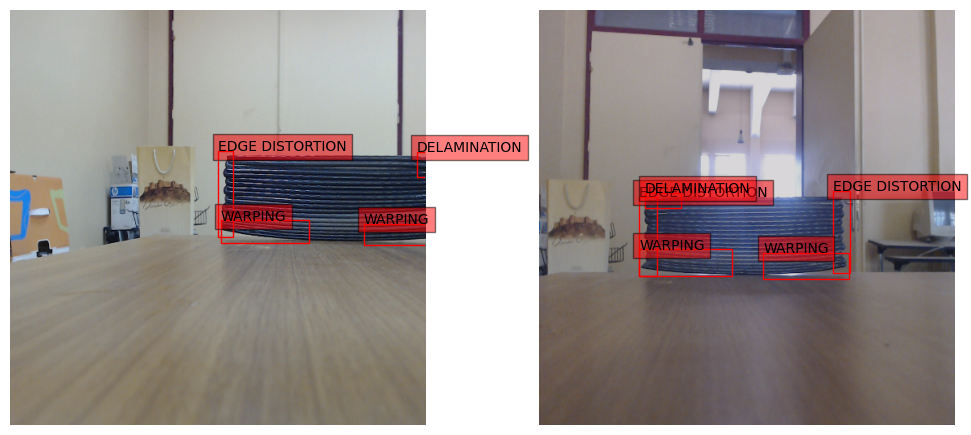

Step 4: Training...


Epoch 1/50 [Train]: 100%|██████████| 83/83 [05:19<00:00,  3.86s/it, loss=0.443]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.24s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 2/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.615]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 3/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.501]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 4/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.247]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 5/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.444]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.21s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 6/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.397]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 7/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.319]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 8/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.209]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 9/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.45s/it, loss=0.336]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.20s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 10/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.325]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 11/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.368]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 12/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.333]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.38s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 13/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.255]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.19s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 14/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.216]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 15/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.167]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 16/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.252]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 17/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.233]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 18/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.237]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 19/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.201]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 20/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.45s/it, loss=0.217]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 21/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.184]


loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 22/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.22]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 23/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.225]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 24/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.169]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 25/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.45s/it, loss=0.171]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 26/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.353]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 27/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.115]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 28/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.145]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 29/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.148]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 30/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.114]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 31/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.186]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 32/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.103]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 33/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.203]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 34/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.45s/it, loss=0.227]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.17s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 35/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.166]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 36/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.152]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 37/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.102]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 38/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.169]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 39/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.138]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 40/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.131]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 41/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.45s/it, loss=0.186]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 42/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.118]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 43/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.0917]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 44/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.126]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 45/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.128]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 46/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.134]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 47/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.0927]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 48/50 [Train]: 100%|██████████| 83/83 [02:00<00:00,  1.45s/it, loss=0.104]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 49/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.0821]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.15s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Epoch 50/50 [Train]: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.1]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.14s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

Evaluation: 100%|██████████| 25/25 [00:51<00:00,  2.05s/it]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.07s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

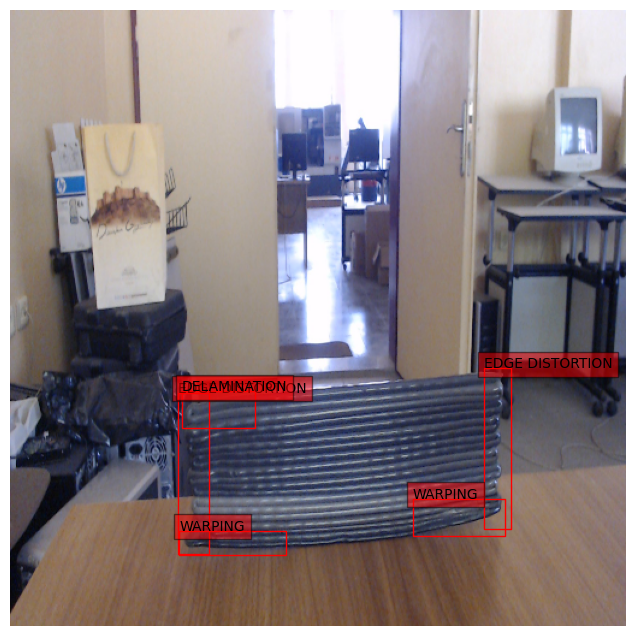

Detected classes: ['EDGE DISTORTION', 'EDGE DISTORTION', 'DELAMINATION', 'WARPING', 'WARPING'], Latency: 73.07 ms
Step 7: Plotting Training History...


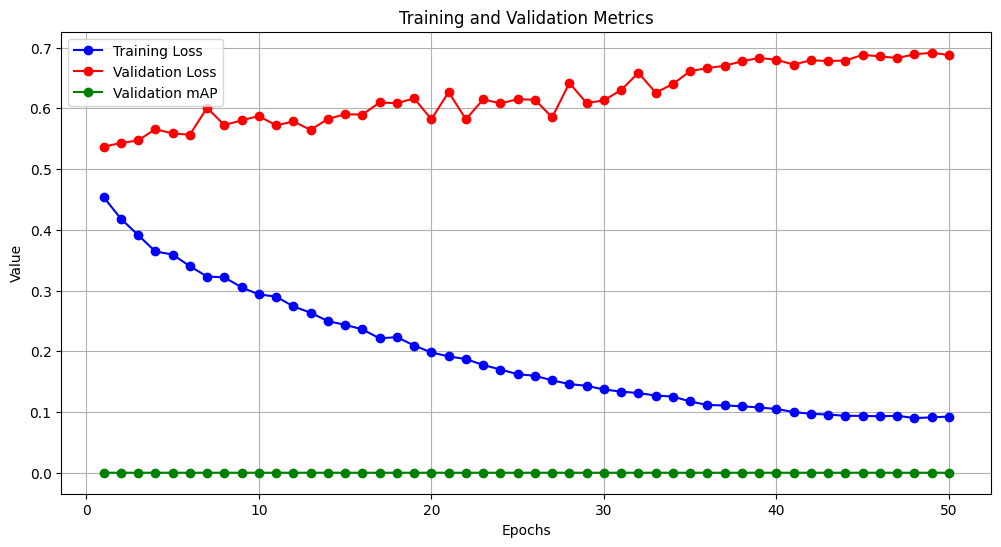

Step 8: Reporting Metrics...


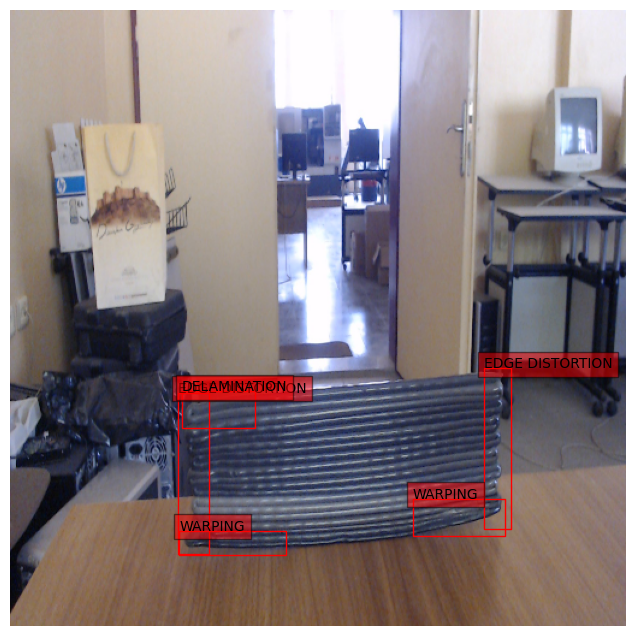

Detected classes: ['EDGE DISTORTION', 'EDGE DISTORTION', 'DELAMINATION', 'WARPING', 'WARPING'], Latency: 73.17 ms
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


Evaluation: 100%|██████████| 25/25 [00:08<00:00,  2.99it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

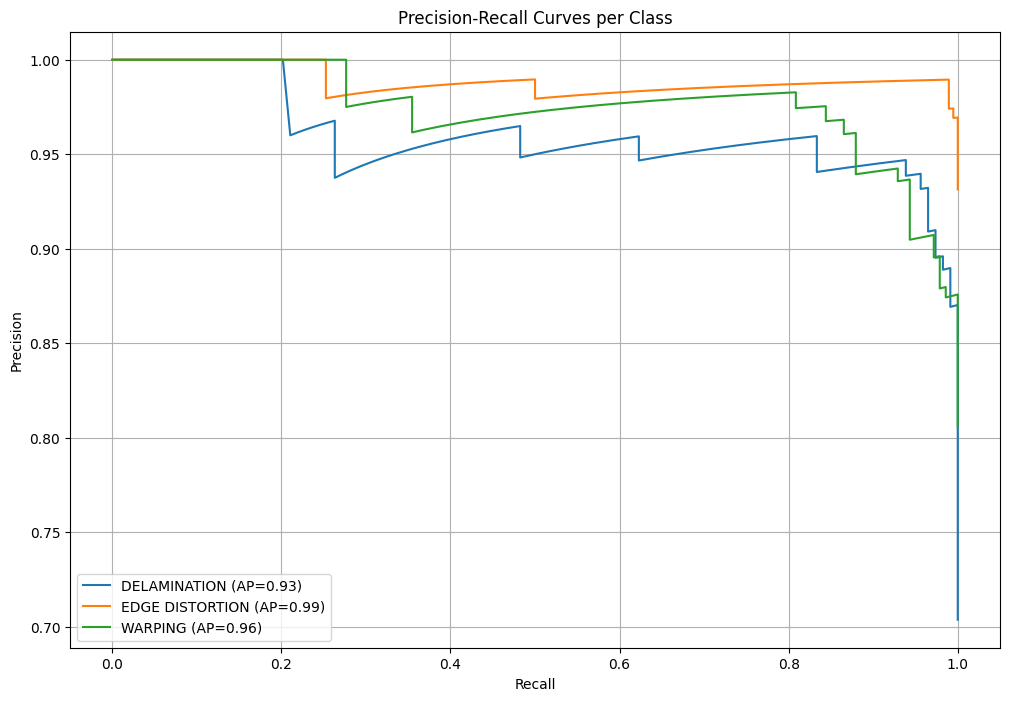

Step 10: Plotting Confusion Matrix...


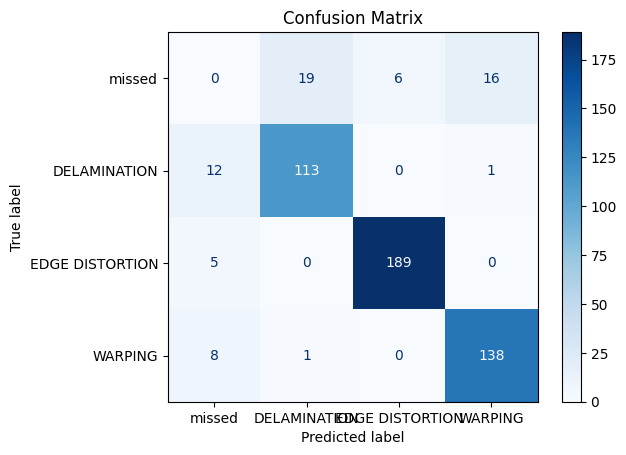

Step 11: Plotting Accuracy vs Epoch and ROC Curves...


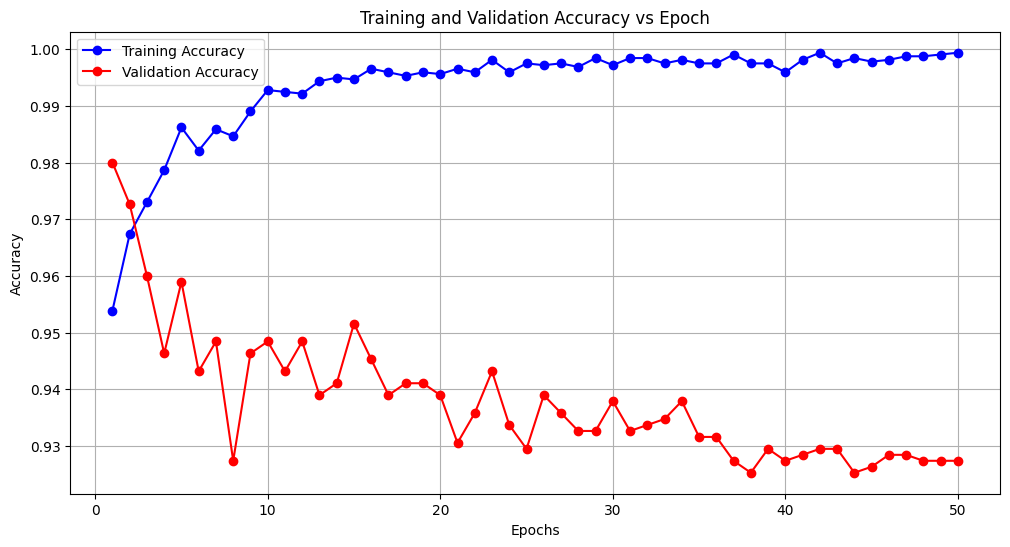

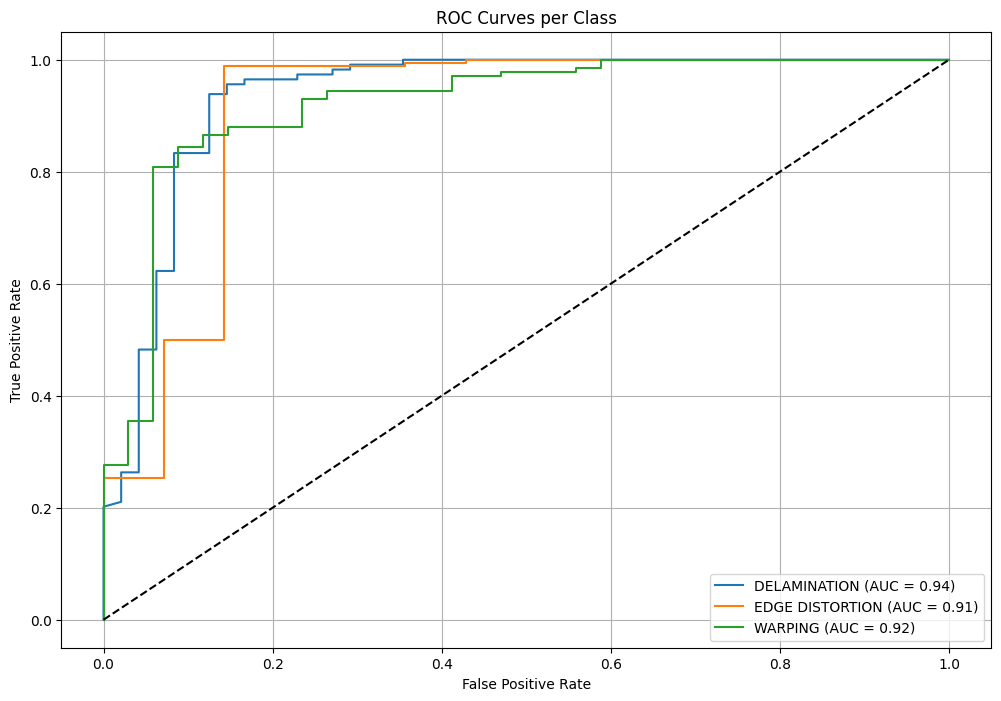

Script completed!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install required libraries
!pip install thop pycocotools albumentations --upgrade -q

import os
import json
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from tqdm import tqdm
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
try:
    import pynvml
    pynvml_available = True
    try:
        pynvml.nvmlInit()
    except pynvml.NVMLError:
        pynvml_available = False
except ImportError:
    pynvml_available = False
from thop import profile
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.amp

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("Warning: No GPU available. Training on CPU will be slower.")

# Paths
base_dir = '/content/drive/MyDrive/Colab Notebooks/dataset_2'
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
valid_dir = os.path.join(base_dir, "valid")
model_save_path = os.path.join(base_dir, "fasterrcnn_model.pth")

# Data augmentation pipeline for training
train_transform = A.Compose([
    A.RandomResizedCrop(height=512, width=512, size=(512, 512), scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0),
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
    A.RandomShadow(p=0.2),
    A.CoarseDropout(num_holes=2, max_height=20, max_width=20, p=0.2),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', min_area=1.0, min_visibility=0.1, label_fields=['labels']))

# Transform for validation and testing (with bbox support)
valid_test_transform = A.Compose([
    A.Resize(height=512, width=512, p=1.0),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', min_area=1.0, min_visibility=0.1, label_fields=['labels']))

# Transform for inference (no bbox support)
inference_transform = A.Compose([
    A.Resize(height=512, width=512, p=1.0),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2(),
])

# Custom Dataset for COCO Annotations
class COCODataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        json_path = os.path.join(directory, "_annotations.coco.json")
        if not os.path.exists(json_path):
            raise FileNotFoundError(f"Annotation file not found at {json_path}")
        print(f"Loading annotations from {json_path}")
        with open(json_path, 'r') as f:
            annotations = json.load(f)

        self.images = {img["id"]: img["file_name"] for img in annotations["images"]}
        self.categories = {cat["id"]: cat["name"] for cat in annotations["categories"]}
        self.annotations = annotations["annotations"]
        self.class_names = sorted(list(self.categories.values()))
        self.label_to_idx = {name: idx + 1 for idx, name in enumerate(self.class_names)}

        self.image_annotations = {}
        for ann in self.annotations:
            image_id = ann["image_id"]
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
            # Filter out invalid boxes (width or height <= 0)
            if ann["bbox"][2] > 0 and ann["bbox"][3] > 0:
                self.image_annotations[image_id].append(ann)
            else:
                print(f"Warning: Skipping invalid box {ann['bbox']} for image_id {image_id}")

        self.image_ids = list(self.image_annotations.keys())
        print(f"Loaded {len(self.image_ids)} images from {directory}")

        # Verify image files exist
        for image_id in self.image_ids:
            image_path = os.path.join(self.directory, self.images[image_id])
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image file not found at {image_path}")

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.directory, self.images[image_id])
        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Failed to load image {image_path}: {e}")
        image = np.array(image)

        annotations = self.image_annotations.get(image_id, [])
        boxes = []
        labels = []
        img_h, img_w = image.shape[:2]
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            # Clip boxes to image boundaries
            x = max(0, x)
            y = max(0, y)
            w = min(w, img_w - x)
            h = min(img_h - y, h)
            if w > 0 and h > 0:  # Only include valid boxes
                boxes.append([x, y, w, h])
                labels.append(self.label_to_idx[self.categories[ann["category_id"]]])

        if self.transform:
            augmented = self.transform(image=image, bboxes=boxes, labels=labels)
            image = augmented['image']
            boxes = augmented['bboxes']
            labels = augmented['labels']

        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        else:
            # Convert to [x_min, y_min, x_max, y_max] and validate
            boxes = [[b[0], b[1], b[0] + b[2], b[1] + b[3]] for b in boxes]
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # Ensure boxes have positive width and height
            valid_boxes = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
            boxes = boxes[valid_boxes]
            labels = torch.as_tensor(labels, dtype=torch.int64)[valid_boxes]
            if len(boxes) == 0:
                boxes = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros(0, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([image_id])}
        return image, target

# Load datasets
print("Loading training dataset...")
train_dataset = COCODataset(train_dir, transform=train_transform)
print("Loading validation dataset...")
valid_dataset = COCODataset(valid_dir, transform=valid_test_transform)
print("Loading test dataset...")
test_dataset = COCODataset(test_dir, transform=valid_test_transform)

# DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

batch_size = 8  # Changed to 8 as requested
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=2)  # Keep test batch size as 4

class_names = train_dataset.class_names
num_classes = len(class_names) + 1
print(f"#classes: {num_classes}")

# Define and Load/Save the Faster R-CNN Model
def create_fasterrcnn_model(num_classes):
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model.to(device)

fasterrcnn_model = create_fasterrcnn_model(num_classes)
optimizer = optim.AdamW(fasterrcnn_model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=50)

if os.path.exists(model_save_path):
    fasterrcnn_model.load_state_dict(torch.load(model_save_path, map_location=device))
    print(f"Loaded model from {model_save_path}")

# Visualize the Dataset
def imshow(img, boxes=None, labels=None, class_names=None, title=None):
    img = img.cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    if boxes is not None and labels is not None and class_names is not None:
        ax = plt.gca()
        for box, label in zip(boxes, labels):
            x_min, y_min, x_max, y_max = box
            if x_max > x_min and y_max > y_min:  # Ensure valid box
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r',
                                         facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min, class_names[label - 1], bbox=dict(facecolor='red', alpha=0.5))
    if title:
        plt.title(title)
    plt.axis("off")

plt.figure(figsize=(10, 5))
images, targets = next(iter(train_loader))
for i in range(min(2, len(images))):
    plt.subplot(1, 2, i + 1)
    imshow(images[i], targets[i]["boxes"], targets[i]["labels"], class_names)
plt.tight_layout()
plt.show()

# Train the Model
def calculate_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_t, y1_t, x2_t, y2_t = box2
    xi1, yi1 = max(x1, x1_t), max(y1, y1_t)
    xi2, yi2 = min(x2, x2_t), min(y2, y2_t)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_t - x1_t) * (y2_t - y1_t)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

def train_model(model, train_loader, valid_loader, optimizer, scheduler, num_epochs=50):
    scaler = torch.amp.GradScaler('cuda')
    history = {'train_loss': [], 'val_loss': [], 'val_mAP': [], 'train_acc': [], 'val_acc': []}
    iou_threshold = 0.5

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]")
        for images, targets in train_bar:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            optimizer.zero_grad()
            with torch.amp.autocast('cuda'):
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += losses.item()
            train_bar.set_postfix(loss=losses.item())

            model.eval()
            with torch.no_grad():
                preds = model(images)
            model.train()
            for p, t in zip(preds, targets):
                pred_boxes = p["boxes"][p["scores"] > 0.5]
                pred_labels = p["labels"][p["scores"] > 0.5]
                gt_boxes = t["boxes"]
                gt_labels = t["labels"]
                train_total += len(gt_boxes)
                matched = torch.zeros(len(gt_boxes), dtype=torch.bool, device=device)
                for pb, pl in zip(pred_boxes, pred_labels):
                    for i, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
                        if matched[i] or pl != gl:
                            continue
                        iou = calculate_iou(pb.cpu().numpy(), gb.cpu().numpy())
                        if iou >= iou_threshold:
                            train_correct += 1
                            matched[i] = True

        train_loss = running_loss / len(train_loader)
        train_acc = train_correct / train_total if train_total > 0 else 0
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for images, targets in valid_loader:
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                # Compute loss
                model.train()
                loss_dict = model(images, targets)
                val_loss += sum(loss for loss in loss_dict.values()).item()
                model.eval()

                # Compute predictions
                preds = model(images)
                filtered_preds = []
                for p in preds:
                    mask = p["scores"] > 0.05
                    filtered_preds.append({
                        "boxes": p["boxes"][mask],
                        "labels": p["labels"][mask],
                        "scores": p["scores"][mask]
                    })
                val_preds.extend(filtered_preds)
                val_targets.extend(targets)
                for p, t in zip(filtered_preds, targets):
                    pred_boxes = p["boxes"]
                    pred_labels = p["labels"]
                    gt_boxes = t["boxes"]
                    gt_labels = t["labels"]
                    val_total += len(gt_boxes)
                    matched = torch.zeros(len(gt_boxes), dtype=torch.bool, device=device)
                    for pb, pl in zip(pred_boxes, pred_labels):
                        for i, (gb, gl) in enumerate(zip(gt_boxes, gt_labels)):
                            if matched[i] or pl != gl:
                                continue
                            iou = calculate_iou(pb.cpu().numpy(), gb.cpu().numpy())
                            if iou >= iou_threshold:
                                val_correct += 1
                                matched[i] = True


        val_loss = val_loss / len(valid_loader)
        val_acc = val_correct / val_total if val_total > 0 else 0
        val_mAP = compute_coco_mAP(val_preds, val_targets, os.path.join(valid_dir, "_annotations.coco.json"))
        history['val_loss'].append(val_loss)
        history['val_mAP'].append(val_mAP)
        history['val_acc'].append(val_acc)

        print(
            f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val mAP: {val_mAP:.4f}"
        )

        scheduler.step()
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved at epoch {epoch + 1} with val_loss: {val_loss:.4f}")

    training_time = time.time() - start_time
    print(f"Total Training Time: {training_time:.2f} seconds ({training_time / 3600:.2f} hours)")
    return history

# Evaluate the Model
def compute_coco_mAP(preds, targets, anno_file):
    coco_gt = COCO(anno_file)
    if 'info' not in coco_gt.dataset:
        coco_gt.dataset['info'] = {}

    anns = [{
        "image_id": int(t["image_id"][0].item()),
        "category_id": int(p["labels"][i].item()),
        "bbox": [p["boxes"][i][0].item(), p["boxes"][i][1].item(),
                 p["boxes"][i][2].item() - p["boxes"][i][0].item(),
                 p["boxes"][i][3].item() - p["boxes"][i][1].item()],
        "score": p["scores"][i].item()
    } for p, t in zip(preds, targets) for i in range(len(p["boxes"])) if len(p["boxes"]) > 0]

    if not anns:
        print("Warning: No valid detections found for mAP computation.")
        return 0.0

    coco_dt = coco_gt.loadRes(anns)
    coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats[0]

def evaluate_model(model, test_loader, anno_file):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluation"):
            images = list(image.to(device) for image in images)
            preds = model(images)
            filtered_preds = []
            for p in preds:
                mask = p["scores"] > 0.05
                filtered_preds.append({
                    "boxes": p["boxes"][mask],
                    "labels": p["labels"][mask],
                    "scores": p["scores"][mask]
                })
            all_preds.extend(filtered_preds)
            all_targets.extend(targets)
    mAP = compute_coco_mAP(all_preds, all_targets, anno_file)
    print(f"Test mAP: {mAP:.4f}")
    return all_preds, all_targets, mAP

# Perform Inference on New Images
def classify_image(model, image_path, class_names, score_threshold=0.5):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)
    img_tensor = inference_transform(image=img_np)['image'].unsqueeze(0).to(device)
    start_time = time.time()
    with torch.no_grad():
        preds = model(img_tensor)[0]
    latency = (time.time() - start_time) * 1000

    boxes = preds["boxes"].cpu().numpy()
    labels = preds["labels"].cpu().numpy()
    scores = preds["scores"].cpu().numpy()
    mask = scores > score_threshold
    boxes, labels, scores = boxes[mask], labels[mask], scores[mask]

    plt.figure(figsize=(8, 8))
    imshow(img_tensor[0], boxes, labels, class_names)
    plt.show()

    detected_classes = [class_names[label - 1] for label in labels]
    print(f"Detected classes: {detected_classes}, Latency: {latency:.2f} ms")
    return detected_classes, latency

# Training History Plot
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.plot(epochs, history['val_mAP'], 'go-', label='Validation mAP')
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Report Metrics
def report_metrics(model, test_loader, image_path):
    _, latency = classify_image(model, image_path, class_names)
    fps = 1000 / latency
    if pynvml_available and torch.cuda.is_available():
        try:
            handle = pynvml.nvmlDeviceGetHandleByIndex(0)
            mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
            gpu_memory = mem_info.used / 1024 ** 2
        except pynvml.NVMLError:
            gpu_memory = "N/A"
    else:
        gpu_memory = "N/A"
    model.eval()
    dummy_input = torch.randn(1, 3, 800, 800).to(device)
    macs, _ = profile(model, inputs=(dummy_input,))
    flops = macs / 1e9
    _, _, mAP = evaluate_model(model, test_loader, os.path.join(test_dir, "_annotations.coco.json"))

    print(
        f"Average Latency: {latency:.2f} ms, FPS: {fps:.2f}, GPU Memory: {gpu_memory}, FLOPs: {flops:.2f} GFLOPs, mAP: {mAP:.4f}")

# Class-wise Precision-Recall (PR) Curves
def plot_pr_curves(preds, targets, class_names):
    plt.figure(figsize=(12, 8))
    iou_threshold = 0.5

    for cls_idx, cls_name in enumerate(class_names, 1):
        y_true, y_scores = [], []

        for p, t in zip(preds, targets):
            true_boxes = t["boxes"].cpu().numpy()
            true_labels = t["labels"].cpu().numpy()
            pred_boxes = p["boxes"].cpu().numpy()
            pred_labels = p["labels"].cpu().numpy()
            pred_scores = p["scores"].cpu().numpy()

            gt_mask = true_labels == cls_idx
            gt_boxes = true_boxes[gt_mask]
            num_gt = len(gt_boxes)

            pred_mask = pred_labels == cls_idx
            pred_boxes_cls = pred_boxes[pred_mask]
            pred_scores_cls = pred_scores[pred_mask]

            if num_gt == 0 and len(pred_boxes_cls) == 0:
                continue

            matched = np.zeros(num_gt, dtype=bool)
            scores = []

            for pred_box, pred_score in zip(pred_boxes_cls, pred_scores_cls):
                max_iou = 0
                max_idx = -1
                for i, gt_box in enumerate(gt_boxes):
                    if matched[i]:
                        continue
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > max_iou:
                        max_iou = iou
                        max_idx = i

                if max_iou >= iou_threshold:
                    y_true.append(1)
                    y_scores.append(pred_score)
                    matched[max_idx] = True
                else:
                    y_true.append(0)
                    y_scores.append(pred_score)

            for i in range(num_gt):
                if not matched[i]:
                    y_true.append(0)
                    y_scores.append(0.0)

        if y_true:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            plt.plot(recall, precision, label=f"{cls_name} (AP={np.mean(precision):.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves per Class")
    plt.legend()
    plt.grid(True)
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(preds, targets, class_names):
    y_true, y_pred = [], []
    iou_threshold = 0.5

    for p, t in zip(preds, targets):
        true_boxes = t["boxes"].cpu().numpy()
        true_labels = t["labels"].cpu().numpy()
        pred_boxes = p["boxes"].cpu().numpy()
        pred_labels = p["labels"].cpu().numpy()
        pred_scores = p["scores"].cpu().numpy()

        num_gt = len(true_boxes)
        matched = np.zeros(num_gt, dtype=bool)

        for pred_box, pred_label, pred_score in zip(pred_boxes, pred_labels, pred_scores):
            if pred_score <= 0.5:
                continue
            max_iou = 0
            max_idx = -1
            for i, gt_box in enumerate(true_boxes):
                if matched[i]:
                    continue
                iou = calculate_iou(pred_box, gt_box)
                if iou > max_iou:
                    max_iou = iou
                    max_idx = i

            if max_iou >= iou_threshold:
                y_true.append(true_labels[max_idx])
                y_pred.append(pred_label)
                matched[max_idx] = True
            else:
                y_true.append(0)
                y_pred.append(pred_label)

        for i in range(num_gt):
            if not matched[i]:
                y_true.append(true_labels[i])
                y_pred.append(0)

    cm = confusion_matrix(y_true, y_pred, labels=range(0, len(class_names) + 1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["missed"] + class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Accuracy vs Epoch and ROC Curves
def plot_accuracy_and_roc(history, preds, targets, class_names):
    epochs = range(1, len(history['train_acc']) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy vs Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 8))
    iou_threshold = 0.5

    for cls_idx, cls_name in enumerate(class_names, 1):
        y_true, y_scores = [], []

        for p, t in zip(preds, targets):
            true_boxes = t["boxes"].cpu().numpy()
            true_labels = t["labels"].cpu().numpy()
            pred_boxes = p["boxes"].cpu().numpy()
            pred_labels = p["labels"].cpu().numpy()
            pred_scores = p["scores"].cpu().numpy()

            gt_mask = true_labels == cls_idx
            gt_boxes = true_boxes[gt_mask]
            num_gt = len(gt_boxes)

            pred_mask = pred_labels == cls_idx
            pred_boxes_cls = pred_boxes[pred_mask]
            pred_scores_cls = pred_scores[pred_mask]

            if num_gt == 0 and len(pred_boxes_cls) == 0:
                continue

            matched = np.zeros(num_gt, dtype=bool)
            for pred_box, pred_score in zip(pred_boxes_cls, pred_scores_cls):
                max_iou = 0
                max_idx = -1
                for i, gt_box in enumerate(gt_boxes):
                    if matched[i]:
                        continue
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > max_iou:
                        max_iou = iou
                        max_idx = i
                if max_iou >= iou_threshold:
                    y_true.append(1)
                    y_scores.append(pred_score)
                    matched[max_idx] = True
                else:
                    y_true.append(0)
                    y_scores.append(pred_score)

            for i in range(num_gt):
                if not matched[i]:
                    y_true.append(0)
                    y_scores.append(0.0)

        if y_true:
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{cls_name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves per Class')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Execute Steps
print("Step 4: Training...")
history = train_model(fasterrcnn_model, train_loader, valid_loader, optimizer, scheduler, num_epochs=50)

print("Step 5: Evaluating...")
test_preds, test_targets, test_mAP = evaluate_model(fasterrcnn_model, test_loader,
                                                    os.path.join(test_dir, "_annotations.coco.json"))

print("Step 6: Inference...")
image_path = os.path.join(test_dir, list(test_dataset.images.values())[0])
classify_image(fasterrcnn_model, image_path, class_names)

print("Step 7: Plotting Training History...")
plot_training_history(history)

print("Step 8: Reporting Metrics...")
report_metrics(fasterrcnn_model, test_loader, image_path)

print("Step 9: Plotting PR Curves...")
plot_pr_curves(test_preds, test_targets, class_names)

print("Step 10: Plotting Confusion Matrix...")
plot_confusion_matrix(test_preds, test_targets, class_names)

print("Step 11: Plotting Accuracy vs Epoch and ROC Curves...")
plot_accuracy_and_roc(history, test_preds, test_targets, class_names)

print("Script completed!")



**02**- DETR

In [ ]:
# Enable inline plotting for Colab
%matplotlib inline

# Install required packages
!pip install thop pycocotools torch torchvision matplotlib numpy tqdm pynvml albumentations -q

import os
import json
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.ops import box_iou, generalized_box_iou
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from torch.cuda.amp import GradScaler, autocast
from scipy.optimize import linear_sum_assignment
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == 'cpu':
    print("Warning: No GPU available. Training on CPU will be slower. Ensure GPU runtime is enabled in Colab.")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths
base_dir = '/content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s'
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
valid_dir = os.path.join(base_dir, "valid")
model_save_path = os.path.join(base_dir, "detr_model_final_working.pth")

# Data augmentation pipeline for training
train_transform = A.Compose([
    A.RandomResizedCrop(size=(512, 512), p=1.0),
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
    A.RandomShadow(p=0.2),
    A.CoarseDropout(num_holes=2, max_height=20, max_width=20, p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Match DETR normalization
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

# Validation/test transform (minimal, no augmentation)
valid_test_transform = A.Compose([
    A.Resize(height=512, width=512, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

# Custom COCODataset with albumentations
class COCODataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.json_path = os.path.join(directory, "_annotations.coco.json")
        self.coco = COCO(self.json_path)
        self.ids = list(sorted(self.coco.imgs.keys()))
        cats = self.coco.loadCats(self.coco.getCatIds())
        self.class_names = [c['name'] for c in cats]
        self.class_name_to_id = {c['name']: c['id'] for c in cats}
        self.id_to_class_name = {v: k for k, v in self.class_name_to_id.items()}

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        coco_annotations = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']
        image = Image.open(os.path.join(self.directory, path)).convert('RGB')
        image = np.array(image)  # Convert to numpy for albumentations

        w, h = image.shape[1], image.shape[0]
        orig_size = torch.as_tensor([int(h), int(w)], dtype=torch.float)

        boxes, labels = [], []
        for ann in coco_annotations:
            x, y, width, height = ann['bbox']
            boxes.append([x, y, width, height])  # COCO format: [x, y, w, h]
            labels.append(ann['category_id'])

        if self.transform:
            augmented = self.transform(image=image, bboxes=boxes, labels=labels)
            image = augmented['image']  # Already a tensor
            boxes = augmented['bboxes']
            labels = augmented['labels']

        # Convert boxes to [x1, y1, x2, y2] format
        boxes = [[x, y, x + w, y + h] for x, y, w, h in boxes] if boxes else []
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4) if boxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros(0, dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([img_id]),
            "orig_size": orig_size
        }
        return image, target

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)

# Helper functions (unchanged)
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    return torch.stack([(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)], dim=-1)

def box_xyxy_to_cxcywh(x):
    x0, y0, x1, y1 = x.unbind(-1)
    return torch.stack([(x0 + x1) / 2, (y0 + y1) / 2, (x1 - x0), (y1 - y0)], dim=-1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    return b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32).to(b.device)

class HungarianMatcher(nn.Module):
    def __init__(self, cost_class: float=1, cost_bbox: float=1, cost_giou: float=1):
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou

    @torch.no_grad()
    def forward(self, outputs, targets):
        bs, num_queries = outputs["pred_logits"].shape[:2]
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)
        out_bbox = outputs["pred_boxes"].flatten(0, 1)
        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])
        cost_class = -out_prob[:, tgt_ids]
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)
        cost_giou = -generalized_box_iou(box_cxcywh_to_xyxy(out_bbox), box_cxcywh_to_xyxy(tgt_bbox))
        C = self.cost_bbox * cost_bbox + self.cost_class * cost_class + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()
        sizes = [len(v["boxes"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]
        return [(torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64)) for i, j in indices]

class SetCriterion(nn.Module):
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[-1] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, o, t, i, n):
        src_logits = o['pred_logits']
        idx = self._get_src_permutation_idx(i)
        t_o = torch.cat([T["labels"][J] for T, (_, J) in zip(t, i)])
        t_c = torch.full(src_logits.shape[:2], self.num_classes, dtype=torch.int64, device=src_logits.device)
        t_c[idx] = t_o
        return {'loss_ce': F.cross_entropy(src_logits.transpose(1, 2), t_c, self.empty_weight)}

    def loss_boxes(self, o, t, i, n):
        idx = self._get_src_permutation_idx(i)
        src = o['pred_boxes'][idx]
        tgt = torch.cat([T['boxes'][J] for T, (_, J) in zip(t, i)], dim=0)
        l1 = F.l1_loss(src, tgt, reduction='none')
        giou = 1 - torch.diag(generalized_box_iou(box_cxcywh_to_xyxy(src), box_cxcywh_to_xyxy(tgt)))
        return {'loss_bbox': l1.sum() / n, 'loss_giou': giou.sum() / n}

    def _get_src_permutation_idx(self, i):
        return torch.cat([torch.full_like(s, j) for j, (s, _) in enumerate(i)]), torch.cat([s for (s, _) in i])

    def get_loss(self, l, o, t, i, n):
        return {'labels': self.loss_labels, 'boxes': self.loss_boxes}[l](o, t, i, n)

    def forward(self, o, t):
        i = self.matcher(o, t)
        n = sum(len(T["labels"]) for T in t)
        n = torch.as_tensor([n], dtype=torch.float, device=next(iter(o.values())).device)
        l = {}
        [l.update(self.get_loss(L, o, t, i, n)) for L in self.losses]
        return l

def calculate_accuracy(outputs, targets, iou_threshold=0.5):
    correct = 0
    total_gt = 0
    device = outputs['pred_logits'].device
    with torch.no_grad():
        for i in range(len(targets)):
            pred_logits = outputs['pred_logits'][i].softmax(-1)
            pred_boxes_norm = outputs['pred_boxes'][i]
            scores, pred_labels = pred_logits[..., :-1].max(-1)
            gt_boxes = targets[i]['boxes'].to(device)
            gt_labels = targets[i]['labels'].to(device)
            total_gt += len(gt_labels)
            pred_boxes = rescale_bboxes(pred_boxes_norm, targets[i]['orig_size'].flip(0))
            keep = scores > 0.5
            pred_boxes = pred_boxes[keep]
            pred_labels = pred_labels[keep]
            if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                continue
            iou_matrix = box_iou(pred_boxes, gt_boxes)
            matches = torch.where(iou_matrix > iou_threshold)
            matched_preds = set()
            matched_gts = set()
            for pred_idx, gt_idx in zip(*matches):
                if pred_labels[pred_idx] == test_dataset.class_names.index(test_dataset.id_to_class_name[gt_labels[gt_idx].item()]):
                    if pred_idx.item() not in matched_preds and gt_idx.item() not in matched_gts:
                        correct += 1
                        matched_preds.add(pred_idx.item())
                        matched_gts.add(gt_idx.item())
    return correct, total_gt

def train_model(model, criterion, train_loader, valid_loader, optimizer, scheduler, num_epochs, device):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    weight_dict = criterion.weight_dict
    scaler = GradScaler()

    for epoch in range(num_epochs):
        model.train()
        criterion.train()
        running_loss, train_correct, train_total = 0.0, 0, 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, targets in train_bar:
            images = [img.to(device) for img in images]
            targets_processed = []
            for t in targets:
                h, w = t['orig_size']
                boxes_xyxy = t['boxes']
                boxes_cxcywh = box_xyxy_to_cxcywh(boxes_xyxy)
                boxes_cxcywh[:, 0::2] /= w
                boxes_cxcywh[:, 1::2] /= h
                targets_processed.append({'labels': t['labels'].to(device), 'boxes': boxes_cxcywh.to(device)})

            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss_dict = criterion(outputs, targets_processed)
                weighted_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys())

            scaler.scale(weighted_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()  # Update learning rate

            running_loss += weighted_loss.item()
            train_bar.set_postfix(loss=weighted_loss.item())
            corr, total = calculate_accuracy(outputs, targets)
            train_correct += corr
            train_total += total

        history['train_loss'].append(running_loss / len(train_loader))
        history['train_acc'].append(train_correct / train_total if train_total > 0 else 0)

        model.eval()
        criterion.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, targets in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Valid]"):
                images = [img.to(device) for img in images]
                targets_processed = []
                for t in targets:
                    h, w = t['orig_size']
                    boxes_xyxy = t['boxes']
                    boxes_cxcywh = box_xyxy_to_cxcywh(boxes_xyxy)
                    boxes_cxcywh[:, 0::2] /= w
                    boxes_cxcywh[:, 1::2] /= h
                    targets_processed.append({'labels': t['labels'].to(device), 'boxes': boxes_cxcywh.to(device)})

                outputs = model(images)
                loss_dict = criterion(outputs, targets_processed)
                weighted_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys())
                val_loss += weighted_loss.item()
                corr, total = calculate_accuracy(outputs, targets)
                val_correct += corr
                val_total += total

        history['val_loss'].append(val_loss / len(valid_loader))
        history['val_acc'].append(val_correct / val_total if val_total > 0 else 0)

        print(f"Epoch [{epoch+1}/{num_epochs}], T.Loss: {history['train_loss'][-1]:.4f}, T.Acc: {history['train_acc'][-1]:.4f}, "
              f"V.Loss: {history['val_loss'][-1]:.4f}, V.Acc: {history['val_acc'][-1]:.4f}")

        torch.save(model.state_dict(), model_save_path)

    return history

@torch.no_grad()
def evaluate_model(model, test_loader, device):
    model.eval()
    coco_gt = test_loader.dataset.coco
    coco_results = []
    for images, targets in tqdm(test_loader, desc="Evaluating for mAP"):
        images = [img.to(device) for img in images]
        with autocast():
            outputs = model(images)
        orig_target_sizes = torch.stack([t["orig_size"] for t in targets], dim=0).to(device)
        logits = outputs['pred_logits'].softmax(-1)
        scores, labels = logits[..., :-1].max(-1)
        for i in range(len(images)):
            scores_i, labels_i, boxes_i = scores[i], labels[i], outputs['pred_boxes'][i]
            rescaled_boxes = rescale_bboxes(boxes_i, orig_target_sizes[i].flip(0))
            for s, l, b in zip(scores_i, labels_i, rescaled_boxes):
                if s > 0.05:
                    box = b.cpu().numpy()
                    x, y, x2, y2 = box
                    w, h = x2 - x, y2 - y
                    coco_results.append({
                        "image_id": targets[i]['image_id'].item(),
                        "category_id": test_loader.dataset.class_name_to_id[test_loader.dataset.class_names[l.item()]],
                        "bbox": [x, y, w, h],
                        "score": s.item()
                    })
    if not coco_results:
        print("No detections found.")
        return 0.0
    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    print(f"\n--- mAP Evaluation ---")
    return coco_eval.stats[0]

@torch.no_grad()
def measure_performance(model, test_loader, device):
    model.eval()
    [model([torch.randn(3, 800, 800).to(device)]) for _ in range(10)]  # Warm-up
    latencies = []
    for images, _ in tqdm(test_loader, desc="Measuring Performance (FPS)"):
        images = [img.to(device) for img in images]
        start_time = time.time()
        with autocast():
            _ = model(images)
        torch.cuda.synchronize()
        end_time = time.time()
        latencies.append((end_time - start_time) * 1000)
    avg_latency = np.mean(latencies)
    fps = 1000 / avg_latency
    print(f"\n--- Performance Metrics ---\nAverage Latency: {avg_latency:.2f} ms\nFrames Per Second (FPS): {fps:.2f}")
    return avg_latency, fps

@torch.no_grad()
def get_predictions_for_plots(model, loader, device, conf_threshold=0.5):
    model.eval()
    all_preds, all_targets = [], []
    for images, targets in tqdm(loader, desc="Getting predictions for plots"):
        images = [img.to(device) for img in images]
        with autocast():
            outputs = model(images)
        logits = outputs['pred_logits'].softmax(-1)
        scores, labels = logits[..., :-1].max(-1)
        for i in range(len(images)):
            keep = scores[i] > conf_threshold
            all_preds.append({
                'scores': scores[i][keep].cpu(),
                'labels': labels[i][keep].cpu(),
                'boxes': rescale_bboxes(outputs['pred_boxes'][i][keep], targets[i]['orig_size'].flip(0)).cpu()
            })
            all_targets.append({
                'labels': targets[i]['labels'],
                'boxes': targets[i]['boxes']
            })
    return all_preds, all_targets

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    epochs = range(1, len(history['train_loss']) + 1)
    ax1.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    ax2.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    plt.show()

def plot_precision_recall_curves(all_preds, all_targets, class_names, class_name_to_id_map):
    plt.figure(figsize=(12, 8))
    iou_threshold = 0.5
    for class_idx, class_name in enumerate(class_names):
        y_true, y_scores = [], []
        model_class_label = class_idx
        coco_class_id = class_name_to_id_map[class_name]
        for preds, targets in zip(all_preds, all_targets):
            gt_mask = targets['labels'] == coco_class_id
            gt_boxes_cls = targets['boxes'][gt_mask]
            pred_mask = preds['labels'] == model_class_label
            pred_boxes_cls = preds['boxes'][pred_mask]
            pred_scores_cls = preds['scores'][pred_mask]
            if len(gt_boxes_cls) == 0 and len(pred_boxes_cls) == 0:
                continue
            matched = np.zeros(len(gt_boxes_cls), dtype=bool)
            if len(pred_boxes_cls) > 0 and len(gt_boxes_cls) > 0:
                iou_matrix = box_iou(pred_boxes_cls, gt_boxes_cls)
                for pred_idx in range(len(pred_boxes_cls)):
                    iou_row = iou_matrix[pred_idx]
                    max_iou, gt_match_idx = iou_row.max(0)
                    if max_iou >= iou_threshold and not matched[gt_match_idx]:
                        y_true.append(1)
                        matched[gt_match_idx] = True
                    else:
                        y_true.append(0)
                    y_scores.append(pred_scores_cls[pred_idx])
            y_true.extend([1] * (len(gt_boxes_cls) - np.sum(matched)))
            y_scores.extend([0] * (len(gt_boxes_cls) - np.sum(matched)))
        if len(y_true) > 0:
            precision, recall, _ = precision_recall_curve(y_true, y_scores)
            plt.plot(recall, precision, lw=2, label=f'{class_name} (AP={np.mean(precision):.2f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve per Class")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_roc_curves(all_preds, all_targets, class_names, class_name_to_id_map):
    plt.figure(figsize=(12, 8))
    iou_threshold = 0.5
    for class_idx, class_name in enumerate(class_names):
        y_true, y_scores = [], []
        model_class_label = class_idx
        coco_class_id = class_name_to_id_map[class_name]
        for preds, targets in zip(all_preds, all_targets):
            gt_mask = targets['labels'] == coco_class_id
            gt_boxes_cls = targets['boxes'][gt_mask]
            pred_mask = preds['labels'] == model_class_label
            pred_boxes_cls = preds['boxes'][pred_mask]
            pred_scores_cls = preds['scores'][pred_mask]
            if len(gt_boxes_cls) == 0 and len(pred_boxes_cls) == 0:
                continue
            y_true_img = np.zeros(len(pred_boxes_cls))
            matched_gts = set()
            if len(pred_boxes_cls) > 0 and len(gt_boxes_cls) > 0:
                iou_matrix = box_iou(pred_boxes_cls, gt_boxes_cls)
                for p_idx in range(len(pred_boxes_cls)):
                    max_iou, gt_idx = iou_matrix[p_idx].max(0)
                    if max_iou >= iou_threshold:
                        y_true_img[p_idx] = 1
                        matched_gts.add(gt_idx.item())
            y_true.extend(y_true_img)
            y_scores.extend(pred_scores_cls.tolist())
            num_unmatched_gts = len(gt_boxes_cls) - len(matched_gts)
            y_true.extend(np.ones(num_unmatched_gts))
            y_scores.extend(np.zeros(num_unmatched_gts))
        if len(y_true) > 0:
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {auc(fpr, tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve per Class')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_confusion_matrix_custom(all_preds, all_targets, class_names, class_name_to_id_map):
    num_classes = len(class_names)
    cm = np.zeros((num_classes + 1, num_classes + 1), dtype=int)
    iou_threshold = 0.5
    id_to_matrix_idx = {coco_id: idx for idx, coco_id in enumerate([class_name_to_id_map[name] for name in sorted(class_name_to_id_map, key=class_name_to_id_map.get)])}

    for preds, targets in zip(all_preds, all_targets):
        gt_boxes, gt_labels = targets['boxes'], targets['labels']
        pred_boxes, pred_labels = preds['boxes'], preds['labels']
        matches = np.zeros(len(gt_boxes), dtype=bool)
        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            iou_matrix = box_iou(pred_boxes, gt_boxes)
            for pred_idx in range(len(pred_boxes)):
                iou_row = iou_matrix[pred_idx]
                max_iou, gt_idx = iou_row.max(0)
                pred_label_idx = pred_labels[pred_idx].item()
                if max_iou >= iou_threshold:
                    if not matches[gt_idx]:
                        gt_label_idx = id_to_matrix_idx[gt_labels[gt_idx].item()]
                        cm[gt_label_idx, pred_label_idx] += 1
                        matches[gt_idx] = True
                    else:
                        cm[num_classes, pred_label_idx] += 1
                else:
                    cm[num_classes, pred_label_idx] += 1
        for gt_idx, matched in enumerate(matches):
            if not matched:
                gt_label_idx = id_to_matrix_idx[gt_labels[gt_idx].item()]
                cm[gt_label_idx, num_classes] += 1
    display_labels = sorted(class_names) + ['Background/Miss']
    disp = ConfusionMatrixDisplay(cm, display_labels=display_labels)
    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Main execution block
if __name__ == '__main__':
    # Create datasets
    train_dataset = COCODataset(train_dir, transform=train_transform)
    valid_dataset = COCODataset(valid_dir, transform=valid_test_transform)
    test_dataset = COCODataset(test_dir, transform=valid_test_transform)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=2)

    # Initialize model
    num_classes = len(train_dataset.class_names)
    detr_model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True, verbose=False)
    detr_model.class_embed = nn.Linear(detr_model.class_embed.in_features, num_classes + 1)
    detr_model.to(device)

    # Initialize criterion and optimizer
    matcher = HungarianMatcher()
    weight_dict = {'loss_ce': 1, 'loss_bbox': 5, 'loss_giou': 2}
    losses = ['labels', 'boxes']
    criterion = SetCriterion(num_classes, matcher=matcher, weight_dict=weight_dict, eos_coef=0.1, losses=losses).to(device)
    param_dicts = [
        {"params": [p for n, p in detr_model.named_parameters() if "backbone" not in n and p.requires_grad]},
        {"params": [p for n, p in detr_model.named_parameters() if "backbone" in n and p.requires_grad], "lr": 1e-5}
    ]
    optimizer = optim.AdamW(param_dicts, lr=1e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

    # Load saved model if exists
    if os.path.exists(model_save_path):
        print(f"Loading saved model from {model_save_path}")
        detr_model.load_state_dict(torch.load(model_save_path))

    NUM_EPOCHS = 50

    print(">>> 1. STARTING TRAINING...")
    history = train_model(detr_model, criterion, train_loader, valid_loader, optimizer, scheduler, num_epochs=NUM_EPOCHS, device=device)

    print("\n>>> 2. STARTING mAP EVALUATION...")
    test_mAP = evaluate_model(detr_model, test_loader, device)

    print("\n>>> 3. STARTING PERFORMANCE MEASUREMENT...")
    avg_latency, fps = measure_performance(detr_model, test_loader, device)

    print("\n>>> 4. GENERATING PLOTS...")
    plot_training_history(history)
    all_preds, all_targets = get_predictions_for_plots(detr_model, test_loader, device)
    plot_precision_recall_curves(all_preds, all_targets, test_dataset.class_names, test_dataset.class_name_to_id)
    plot_roc_curves(all_preds, all_targets, test_dataset.class_names, test_dataset.class_name_to_id)
    plot_confusion_matrix_custom(all_preds, all_targets, test_dataset.class_names, test_dataset.class_name_to_id)

    print("\n--- SCRIPT COMPLETED ---")



Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
  Cloning https://github.com/facebookresearch/detr.git to /tmp/pip-req-build-pe1i1x9i
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detr.git /tmp/pip-req-build-pe1i1x9i
  Resolved https://github.com/facebookresearch/detr.git to commit 29901c51d7fe8712168b8d0d64351170bc0f83e0
ERROR: git+https://github.com/facebookresearch/detr.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


ModuleNotFoundError: No module named 'thop'

**03**- YOLOV8

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/train
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/valid
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/train/_annotations.coco.json
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/valid/_annotations.coco.json
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test/_annotations.coco.json
Converting COCO to YOLO format...
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
train images: 511 files
train labels: 511 file

train: Scanning /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/train_yolo/labels.cache... 511 images, 0 backgrounds, 0 corrupt: 100%|██████████| 511/511 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 104.1±53.9 MB/s, size: 236.4 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/valid_yolo/labels.cache... 146 images, 0 backgrounds, 0 corrupt: 100%|██████████| 146/146 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/detect/train4
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.443G      2.333      2.754      1.517         36        512: 100%|██████████| 128/128 [00:10<00:00, 11.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 16.20it/s]


                   all        146        754      0.745      0.624      0.602      0.254

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.443G      1.968      1.575      1.318         31        512: 100%|██████████| 128/128 [00:10<00:00, 12.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 16.99it/s]

                   all        146        754      0.644      0.666      0.637      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.447G      1.908      1.463      1.296         27        512: 100%|██████████| 128/128 [00:09<00:00, 12.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 16.57it/s]

                   all        146        754      0.641      0.699      0.683      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.449G      1.861       1.39      1.289         13        512: 100%|██████████| 128/128 [00:09<00:00, 13.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 16.08it/s]

                   all        146        754      0.718       0.74      0.761      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.449G      1.829      1.299      1.248         33        512: 100%|██████████| 128/128 [00:09<00:00, 13.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 15.94it/s]


                   all        146        754      0.787      0.767      0.803      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.449G      1.787      1.285      1.253         22        512: 100%|██████████| 128/128 [00:09<00:00, 13.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.01it/s]

                   all        146        754      0.715      0.739      0.771      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.465G      1.774      1.241      1.252         27        512: 100%|██████████| 128/128 [00:09<00:00, 13.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.02it/s]


                   all        146        754      0.786      0.796      0.836      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.465G      1.747      1.181       1.23         19        512: 100%|██████████| 128/128 [00:09<00:00, 13.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.27it/s]

                   all        146        754      0.809      0.782      0.845      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.465G      1.725      1.157      1.214         47        512: 100%|██████████| 128/128 [00:09<00:00, 13.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.15it/s]

                   all        146        754      0.804      0.846      0.853      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.482G       1.71      1.132      1.196         32        512: 100%|██████████| 128/128 [00:09<00:00, 12.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.35it/s]

                   all        146        754      0.833      0.838      0.882      0.398


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.496G      1.666      1.152      1.252         12        512: 100%|██████████| 128/128 [00:10<00:00, 12.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 16.65it/s]

                   all        146        754      0.804      0.832      0.857       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.498G      1.665      1.108      1.229         12        512: 100%|██████████| 128/128 [00:09<00:00, 13.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.25it/s]

                   all        146        754      0.819      0.879      0.885      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.498G       1.64       1.08      1.219         15        512: 100%|██████████| 128/128 [00:09<00:00, 13.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.55it/s]

                   all        146        754       0.86      0.862       0.91      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.498G      1.628      1.072      1.208         18        512: 100%|██████████| 128/128 [00:09<00:00, 13.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 16.21it/s]

                   all        146        754      0.878      0.892      0.923      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.498G      1.591       1.05      1.203         18        512: 100%|██████████| 128/128 [00:09<00:00, 13.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 16.81it/s]

                   all        146        754      0.906      0.878      0.938       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.498G      1.581      1.027      1.184         17        512: 100%|██████████| 128/128 [00:09<00:00, 13.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.32it/s]

                   all        146        754      0.896      0.884       0.93      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.498G      1.569     0.9838      1.177         16        512: 100%|██████████| 128/128 [00:09<00:00, 13.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.55it/s]

                   all        146        754       0.92      0.892      0.947      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.498G      1.577     0.9747      1.187         15        512: 100%|██████████| 128/128 [00:09<00:00, 12.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 16.99it/s]

                   all        146        754      0.917      0.906      0.946      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.498G      1.537     0.9566      1.165         20        512: 100%|██████████| 128/128 [00:10<00:00, 12.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.53it/s]

                   all        146        754      0.914      0.912      0.947      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20     0.498G      1.538     0.9451      1.163         12        512: 100%|██████████| 128/128 [00:09<00:00, 12.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.79it/s]

                   all        146        754      0.926      0.903      0.945      0.464



20 epochs completed in 0.063 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 13.58it/s]


                   all        146        754      0.924      0.904      0.945      0.465
                class1         92        196      0.908      0.847      0.923      0.426
                class2        144        288      0.984      0.997      0.982      0.568
                class3        135        270       0.88      0.869       0.93      0.402
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train4
Training metrics loaded from results.csv
Number of epochs logged: 10
Columns in results.csv: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
Plotting metrics for 10 epochs


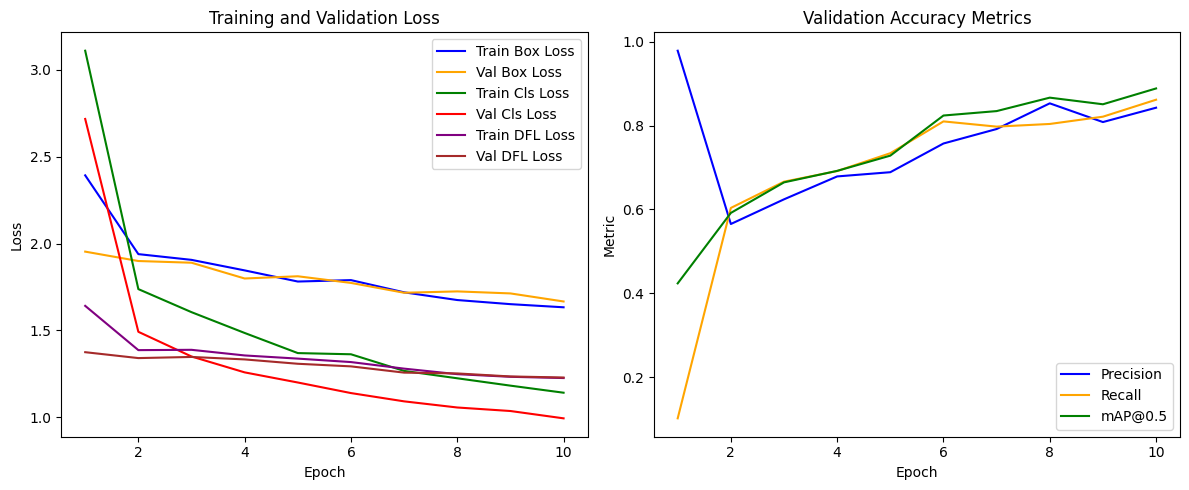

Evaluating on test set...
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.3±0.0 ms, read: 124.5±27.2 MB/s, size: 213.5 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/labels.cache... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:01<00:00, 17.17it/s]


                   all         74        384      0.892      0.894      0.914      0.467
                class1         53        105       0.83       0.79      0.819      0.395
                class2         74        148      0.983          1      0.995      0.581
                class3         66        131      0.864      0.893      0.928      0.424
Speed: 0.8ms preprocess, 6.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train42
Test mAP@0.5: 0.9139, mAP@0.5:0.95: 0.4667

image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_09_39_28_Pro.jpg: 288x512 1 class1, 2 class2s, 1 class3, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 512)

image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_09_39_30_Pro.jpg: 288x512 1 class1, 2 class2s, 1 class3, 6.8ms
Speed: 1.5ms preprocess, 6.8ms inference, 1.6ms postprocess per 

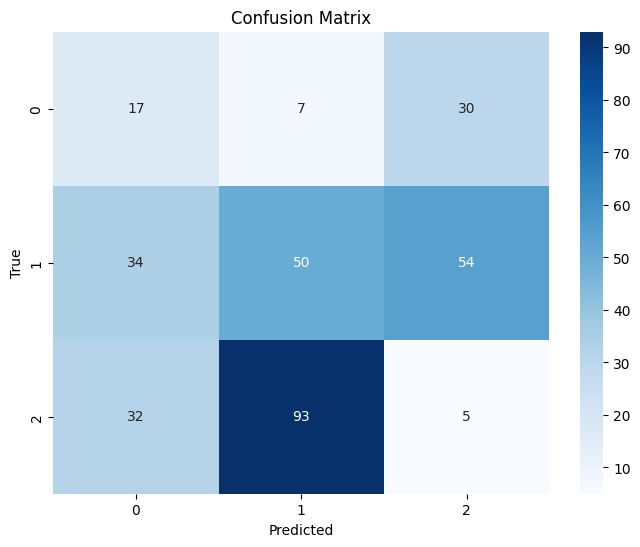

Test mAP@0.5: 0.9139, mAP@0.5:0.95: 0.4667, FPS: 36.06

image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_10_23_40_Pro.jpg: 288x512 2 class1s, 2 class2s, 2 class3s, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 512)


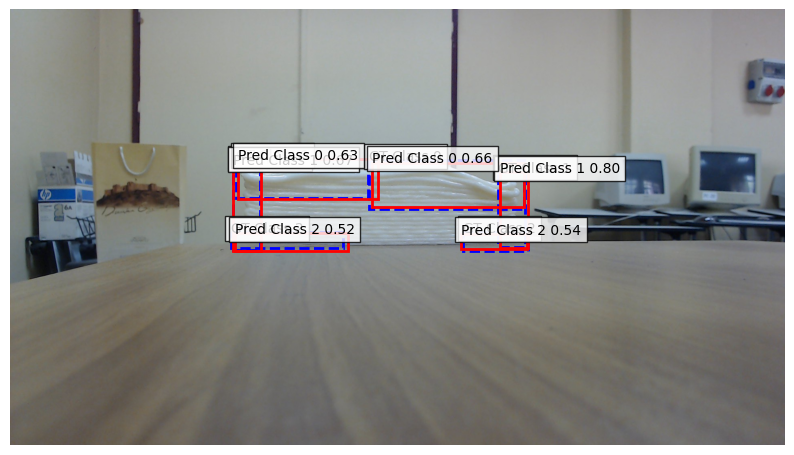


image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_10_27_13_Pro.jpg: 288x512 2 class1s, 2 class2s, 1 class3, 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 512)


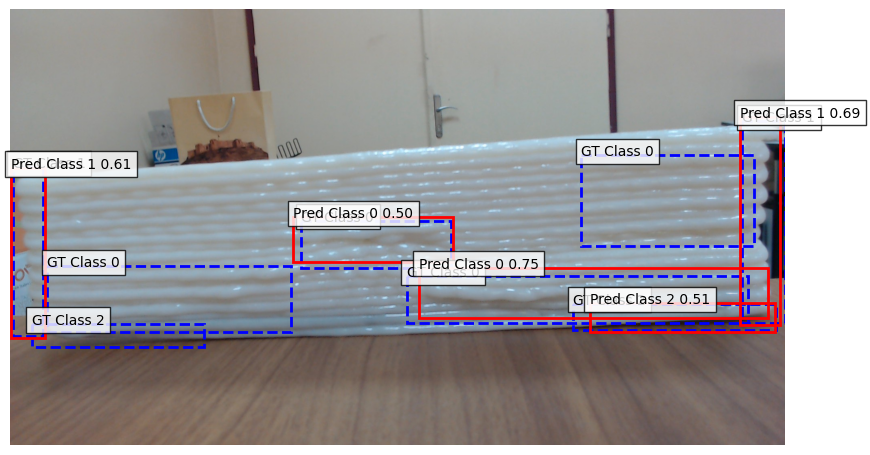


image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_10_12_35_Pro.jpg: 288x512 2 class1s, 2 class2s, 2 class3s, 8.5ms
Speed: 1.6ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 288, 512)


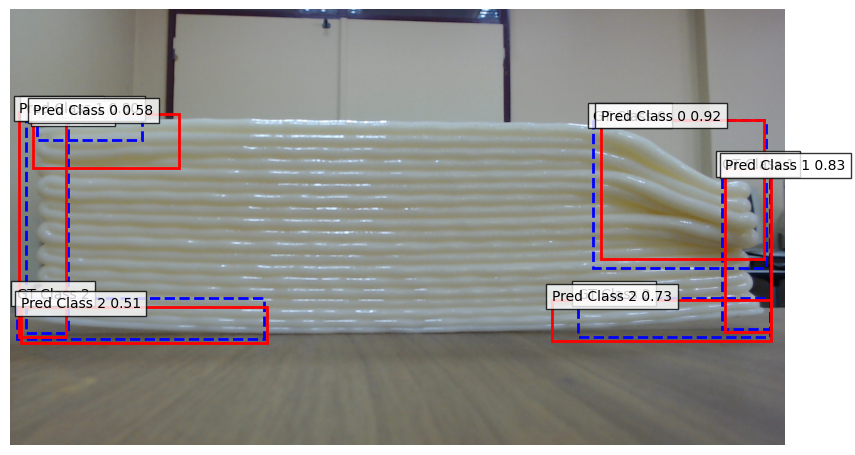

In [ ]:
# Enable inline plotting for Colab
%matplotlib inline

# Install required packages
!pip install ultralytics torch torchvision pycocotools opencv-python-headless matplotlib seaborn pandas

import os
import torch
from ultralytics import YOLO
from pycocotools.coco import COCO
import numpy as np
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cpu':
    print("Warning: No GPU available. Training on CPU will be slower. Ensure GPU runtime is enabled in Colab.")

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s'  # Update with your dataset path
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
VALID_DIR = os.path.join(BASE_PATH, 'valid')
TEST_DIR = os.path.join(BASE_PATH, 'test')
TRAIN_ANNOT = os.path.join(TRAIN_DIR, '_annotations.coco.json')
VALID_ANNOT = os.path.join(VALID_DIR, '_annotations.coco.json')
TEST_ANNOT = os.path.join(TEST_DIR, '_annotations.coco.json')

# Validate dataset paths
for path in [TRAIN_DIR, VALID_DIR, TEST_DIR, TRAIN_ANNOT, VALID_ANNOT, TEST_ANNOT]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Path does not exist: {path}")
    print(f"Path exists: {path}")

# Function to convert COCO to YOLO format (run only if not already converted)
def convert_coco_to_yolo(coco_json, img_dir, output_dir):
    coco = COCO(coco_json)
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)

    for img_id in coco.getImgIds():
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info['file_name'])
        img_width, img_height = img_info['width'], img_info['height']

        # Copy image to output directory
        output_img_path = os.path.join(output_dir, 'images', img_info['file_name'])
        if os.path.exists(img_path):
            os.system(f"cp '{img_path}' '{output_img_path}'")
        else:
            print(f"Warning: Image not found: {img_path}")
            continue

        # Convert annotations
        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)
        label_path = os.path.join(output_dir, 'labels', img_info['file_name'].rsplit('.', 1)[0] + '.txt')

        with open(label_path, 'w') as f:
            for ann in annotations:
                x, y, w, h = ann['bbox']
                # Convert to YOLO format: [class_id, x_center, y_center, width, height] (normalized)
                class_id = ann['category_id'] - 1  # YOLO uses 0-based class IDs
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                w_norm = w / img_width
                h_norm = h / img_height

                # Validate normalized coordinates
                if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= w_norm <= 1 and 0 <= h_norm <= 1):
                    print(f"Warning: Invalid normalized coordinates for image ID {img_id}: {[x_center, y_center, w_norm, h_norm]}")
                    continue

                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

# Convert COCO to YOLO format (comment out if already done)
TRAIN_YOLO_DIR = os.path.join(BASE_PATH, 'train_yolo')
VALID_YOLO_DIR = os.path.join(BASE_PATH, 'valid_yolo')
TEST_YOLO_DIR = os.path.join(BASE_PATH, 'test_yolo')

print("Converting COCO to YOLO format...")
convert_coco_to_yolo(TRAIN_ANNOT, TRAIN_DIR, TRAIN_YOLO_DIR)
convert_coco_to_yolo(VALID_ANNOT, VALID_DIR, VALID_YOLO_DIR)
convert_coco_to_yolo(TEST_ANNOT, TEST_DIR, TEST_YOLO_DIR)

# Create data.yaml
data_yaml_content = f"""
train: {TRAIN_YOLO_DIR}/images
val: {VALID_YOLO_DIR}/images
test: {TEST_YOLO_DIR}/images
nc: 3  # Number of classes
names: ['class1', 'class2', 'class3']  # Replace with actual class names
"""
with open(os.path.join(BASE_PATH, 'data.yaml'), 'w') as f:
    f.write(data_yaml_content)

# Validate YOLO dataset
for split, yolo_dir in [('train', TRAIN_YOLO_DIR), ('valid', VALID_YOLO_DIR), ('test', TEST_YOLO_DIR)]:
    img_dir = os.path.join(yolo_dir, 'images')
    label_dir = os.path.join(yolo_dir, 'labels')
    if not os.path.exists(img_dir) or not os.path.exists(label_dir):
        raise FileNotFoundError(f"Missing images or labels directory in {yolo_dir}")
    print(f"{split} images: {len(os.listdir(img_dir))} files")
    print(f"{split} labels: {len(os.listdir(label_dir))} files")

# Initialize YOLOv8 model
try:
    model = YOLO('yolov8n.pt')  # Use yolov8n (nano) for faster training
    model.to(device)
except Exception as e:
    print(f"Error initializing YOLOv8 model: {e}")
    raise

# Training
try:
    results = model.train(
        data=os.path.join(BASE_PATH, 'data.yaml'),
        epochs=50,
        imgsz=512,
        batch=8,
        device=device,
        patience=0,  # Disable early stopping
        verbose=True,
        project='runs/detect',  # Save training results
        name='train'
    )
except Exception as e:
    print(f"Error during training: {e}")
    raise

# Load training metrics from CSV
results_csv = os.path.join('runs/detect/train', 'results.csv')
if os.path.exists(results_csv):
    metrics_df = pd.read_csv(results_csv)
    metrics_df.columns = metrics_df.columns.str.strip()  # Remove leading/trailing spaces
    print("Training metrics loaded from results.csv")
    print(f"Number of epochs logged: {len(metrics_df)}")
    print("Columns in results.csv:", metrics_df.columns.tolist())
else:
    raise FileNotFoundError(f"Training results CSV not found at {results_csv}")

# Plot loss and accuracy curves
def plot_training_metrics(metrics_df, num_epochs):
    # Use the actual number of logged epochs
    num_logged_epochs = len(metrics_df)
    epochs = range(1, num_logged_epochs + 1)
    print(f"Plotting metrics for {num_logged_epochs} epochs")

    # Loss curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics_df['train/box_loss'][:num_logged_epochs], label='Train Box Loss', color='blue')
    plt.plot(epochs, metrics_df['val/box_loss'][:num_logged_epochs], label='Val Box Loss', color='orange')
    plt.plot(epochs, metrics_df['train/cls_loss'][:num_logged_epochs], label='Train Cls Loss', color='green')
    plt.plot(epochs, metrics_df['val/cls_loss'][:num_logged_epochs], label='Val Cls Loss', color='red')
    plt.plot(epochs, metrics_df['train/dfl_loss'][:num_logged_epochs], label='Train DFL Loss', color='purple')
    plt.plot(epochs, metrics_df['val/dfl_loss'][:num_logged_epochs], label='Val DFL Loss', color='brown')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics_df['metrics/precision(B)'][:num_logged_epochs], label='Precision', color='blue')
    plt.plot(epochs, metrics_df['metrics/recall(B)'][:num_logged_epochs], label='Recall', color='orange')
    plt.plot(epochs, metrics_df['metrics/mAP50(B)'][:num_logged_epochs], label='mAP@0.5', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Validation Accuracy Metrics')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot metrics
plot_training_metrics(metrics_df, num_epochs=20)

# Evaluation on test set
def evaluate_yolo(model, test_dir, imgsz=512):
    model.eval()
    results = model.val(data=os.path.join(BASE_PATH, 'data.yaml'), split='test', imgsz=imgsz, device=device)

    # Extract metrics
    mAP50 = results.box.map50
    mAP = results.box.map
    print(f"Test mAP@0.5: {mAP50:.4f}, mAP@0.5:0.95: {mAP:.4f}")

    # Calculate FPS
    inference_times = []
    test_images = [os.path.join(test_dir, 'images', f) for f in os.listdir(os.path.join(test_dir, 'images')) if f.endswith(('.jpg', '.png'))]
    for img_path in test_images[:10]:  # Test on first 10 images for FPS
        start_time = time.time()
        model.predict(img_path, imgsz=imgsz, device=device)
        inference_times.append(time.time() - start_time)

    avg_time = sum(inference_times) / len(inference_times) if inference_times else 0
    fps = 1 / avg_time if avg_time > 0 else 0
    print(f"Average FPS: {fps:.2f}")

    # Confusion matrix with aligned labels
    true_labels = []
    pred_labels = []
    for img_path in test_images:
        label_path = os.path.join(test_dir, 'labels', os.path.basename(img_path).rsplit('.', 1)[0] + '.txt')
        img_true_labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                img_true_labels = [int(line.split()[0]) for line in f.readlines()]

        preds = model.predict(img_path, imgsz=imgsz, device=device, conf=0.5)
        img_pred_labels = []
        for pred in preds:
            if pred.boxes.cls is not None:
                img_pred_labels.extend(pred.boxes.cls.cpu().numpy().astype(int))

        # Align labels: only include pairs where both true and pred labels exist
        min_len = min(len(img_true_labels), len(img_pred_labels))
        if min_len > 0:
            true_labels.extend(img_true_labels[:min_len])
            pred_labels.extend(img_pred_labels[:min_len])
        elif len(img_true_labels) > 0 and len(img_pred_labels) == 0:
            print(f"Warning: No predictions for image {os.path.basename(img_path)} with {len(img_true_labels)} ground truth labels")
        elif len(img_pred_labels) > 0 and len(img_true_labels) == 0:
            print(f"Warning: No ground truth labels for image {os.path.basename(img_path)} with {len(img_pred_labels)} predictions")

        print(f"Image {os.path.basename(img_path)}: {len(img_true_labels)} true labels, {len(img_pred_labels)} pred labels")

    # Generate confusion matrix if labels are available
    if true_labels and pred_labels:
        cm = confusion_matrix(true_labels, pred_labels, labels=range(3))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    else:
        print("No valid label pairs for confusion matrix")

    return mAP50, mAP, fps

# Run evaluation
print("Evaluating on test set...")
mAP50, mAP, fps = evaluate_yolo(model, TEST_YOLO_DIR)
print(f"Test mAP@0.5: {mAP50:.4f}, mAP@0.5:0.95: {mAP:.4f}, FPS: {fps:.2f}")

# Visualize multiple predictions
def visualize_multiple_predictions_yolo(model, test_dir, num_samples=3, imgsz=512):
    model.eval()
    test_images = [os.path.join(test_dir, 'images', f) for f in os.listdir(os.path.join(test_dir, 'images')) if f.endswith(('.jpg', '.png'))]
    indices = np.random.choice(len(test_images), min(num_samples, len(test_images)), replace=False)

    for idx in indices:
        img_path = test_images[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_height, img_width = img.shape[:2]

        # Ground truth boxes
        label_path = os.path.join(test_dir, 'labels', os.path.basename(img_path).rsplit('.', 1)[0] + '.txt')
        gt_boxes = []
        gt_labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    class_id, x_center, y_center, w, h = map(float, line.strip().split())
                    x_min = (x_center - w / 2) * img_width
                    y_min = (y_center - h / 2) * img_height
                    x_max = (x_center + w / 2) * img_width
                    y_max = (y_center + h / 2) * img_height
                    gt_boxes.append([x_min, y_min, x_max, y_max])
                    gt_labels.append(int(class_id))

        # Predictions
        preds = model.predict(img_path, imgsz=imgsz, device=device, conf=0.5)

        plt.figure(figsize=(10, 10))
        plt.imshow(img)

        # Plot ground truth boxes
        for box, label in zip(gt_boxes, gt_labels):
            x_min, y_min, x_max, y_max = box
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                            fill=False, color='blue', linewidth=2, linestyle='--'))
            plt.text(x_min, y_min, f'GT Class {label}',
                    bbox=dict(facecolor='white', alpha=0.8))

        # Plot predicted boxes
        for pred in preds:
            if pred.boxes.xyxy is not None:
                boxes = pred.boxes.xyxy.cpu().numpy()
                scores = pred.boxes.conf.cpu().numpy()
                labels = pred.boxes.cls.cpu().numpy().astype(int)
                for box, score, label in zip(boxes, scores, labels):
                    x_min, y_min, x_max, y_max = box
                    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                                    fill=False, color='red', linewidth=2))
                    plt.text(x_min, y_min, f'Pred Class {label} {score:.2f}',
                            bbox=dict(facecolor='white', alpha=0.8))

        plt.axis('off')
        plt.show()

# Visualize 3 samples
visualize_multiple_predictions_yolo(model, TEST_YOLO_DIR, num_samples=3)


03-YOLOV8 V2

Using device: cpu
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/train
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/valid
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/train/_annotations.coco.json
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/valid/_annotations.coco.json
Path exists: /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test/_annotations.coco.json
Converting COCO to YOLO format...
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
train images: 511 files
train labels: 511 files

/tmp/ipython-input-1500884408.py:120: UserWarning: Argument(s) 'height, width' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(height=512, width=512, size=(512, 512), p=1.0),
/tmp/ipython-input-1500884408.py:125: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
/tmp/ipython-input-1500884408.py:127: UserWarning: Argument(s) 'num_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(num_holes=2, max_height=20, max_width=20, p=0.2),


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=0, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=runs/detect, rec

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    751897  ultralytics.nn.modules.head.Detect           [3, [64, 128, 256]]           
Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.5±0.1 ms, read: 58.5±28.1 MB/s, size: 223.8 KB)


train: Scanning /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/train_yolo/labels.cache... 511 images, 0 backgrounds, 0 corrupt: 100%|██████████| 511/511 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 8.6±18.2 ms, read: 53.4±33.0 MB/s, size: 236.4 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/valid_yolo/labels.cache... 146 images, 0 backgrounds, 0 corrupt: 100%|██████████| 146/146 [00:00<?, ?it/s]

Plotting labels to runs/detect/train2/labels.jpg... 


optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.306      3.041      1.588         71        512: 100%|██████████| 64/64 [05:30<00:00,  5.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.15s/it]

                   all        146        754     0.0175       0.74      0.233      0.075



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.032      2.117      1.415         60        512: 100%|██████████| 64/64 [05:10<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

                   all        146        754      0.448      0.354      0.433      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.974       1.79      1.372         71        512: 100%|██████████| 64/64 [05:09<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.19s/it]

                   all        146        754      0.564      0.598      0.558      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.939      1.637       1.31         67        512: 100%|██████████| 64/64 [05:12<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.09s/it]

                   all        146        754      0.631      0.617      0.609      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.916       1.55      1.311         70        512: 100%|██████████| 64/64 [05:10<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.10s/it]

                   all        146        754      0.701      0.644      0.662      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.859      1.493      1.293         63        512: 100%|██████████| 64/64 [05:17<00:00,  4.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

                   all        146        754      0.741      0.657      0.695       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.817      1.415      1.257         57        512: 100%|██████████| 64/64 [05:09<00:00,  4.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.15s/it]

                   all        146        754      0.719      0.688      0.697       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.806      1.387      1.247         69        512: 100%|██████████| 64/64 [05:10<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]

                   all        146        754       0.78      0.695      0.724      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.793      1.349      1.226         83        512: 100%|██████████| 64/64 [05:10<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

                   all        146        754      0.745       0.71      0.727      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.783      1.315      1.233         55        512: 100%|██████████| 64/64 [05:11<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:22<00:00,  2.24s/it]

                   all        146        754      0.791      0.725      0.754      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.764      1.292      1.218         55        512: 100%|██████████| 64/64 [05:12<00:00,  4.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

                   all        146        754      0.771      0.736      0.773      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.742      1.263      1.204         77        512: 100%|██████████| 64/64 [05:12<00:00,  4.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:22<00:00,  2.22s/it]

                   all        146        754      0.802      0.743      0.788       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.749      1.253      1.215         68        512: 100%|██████████| 64/64 [05:13<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]

                   all        146        754      0.799      0.755      0.803      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.724      1.238      1.201         76        512: 100%|██████████| 64/64 [05:16<00:00,  4.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]

                   all        146        754      0.822      0.751      0.805      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.718      1.213      1.185         73        512: 100%|██████████| 64/64 [05:12<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

                   all        146        754      0.773       0.77      0.808      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.738      1.198      1.185         69        512: 100%|██████████| 64/64 [05:11<00:00,  4.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.13s/it]

                   all        146        754      0.796      0.781      0.815      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.702      1.185       1.18         47        512: 100%|██████████| 64/64 [05:09<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]

                   all        146        754      0.823      0.774      0.825      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.697      1.162      1.188         65        512: 100%|██████████| 64/64 [05:08<00:00,  4.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

                   all        146        754      0.828      0.791      0.828      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.676      1.147       1.18         68        512: 100%|██████████| 64/64 [05:17<00:00,  4.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

                   all        146        754      0.798      0.804      0.835      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.677      1.144      1.162         95        512: 100%|██████████| 64/64 [05:07<00:00,  4.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.14s/it]

                   all        146        754      0.852      0.801      0.859      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.658      1.146      1.169         73        512: 100%|██████████| 64/64 [05:10<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.16s/it]

                   all        146        754      0.847      0.794      0.859      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.691      1.132      1.167         94        512: 100%|██████████| 64/64 [05:07<00:00,  4.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.10s/it]

                   all        146        754      0.827      0.825      0.855      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.656       1.12      1.159         85        512: 100%|██████████| 64/64 [05:11<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

                   all        146        754      0.846       0.83      0.867      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.686      1.126      1.179         56        512: 100%|██████████| 64/64 [05:09<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  2.00s/it]

                   all        146        754      0.849      0.807      0.862      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.656      1.108      1.153         67        512: 100%|██████████| 64/64 [05:09<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]

                   all        146        754      0.848      0.835       0.88      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.677      1.107      1.158         88        512: 100%|██████████| 64/64 [05:09<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.17s/it]

                   all        146        754      0.845      0.823      0.878      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.678      1.084      1.152         87        512: 100%|██████████| 64/64 [05:07<00:00,  4.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.11s/it]

                   all        146        754      0.854       0.83      0.888      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.646      1.092      1.161         71        512: 100%|██████████| 64/64 [05:08<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

                   all        146        754      0.845      0.859      0.885       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.629      1.091       1.15         99        512: 100%|██████████| 64/64 [05:10<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

                   all        146        754      0.847       0.84      0.885       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.635      1.083      1.147         68        512: 100%|██████████| 64/64 [05:12<00:00,  4.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

                   all        146        754      0.844      0.845      0.887      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.612      1.064      1.139         36        512: 100%|██████████| 64/64 [05:13<00:00,  4.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

                   all        146        754      0.852      0.851      0.894      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.632      1.073      1.138         76        512: 100%|██████████| 64/64 [05:12<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

                   all        146        754      0.864       0.84      0.896      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.634      1.068      1.144         60        512: 100%|██████████| 64/64 [05:12<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]

                   all        146        754      0.867       0.85      0.901      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.635      1.073      1.149         45        512: 100%|██████████| 64/64 [05:12<00:00,  4.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

                   all        146        754      0.876      0.853        0.9      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.622      1.051      1.146         62        512: 100%|██████████| 64/64 [05:12<00:00,  4.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.06s/it]

                   all        146        754      0.876      0.837      0.893      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.624      1.051      1.145         79        512: 100%|██████████| 64/64 [05:11<00:00,  4.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

                   all        146        754      0.866      0.854      0.905      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G       1.62      1.059      1.157         89        512: 100%|██████████| 64/64 [05:13<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.15s/it]

                   all        146        754      0.858      0.861      0.901      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.631      1.068      1.155         80        512: 100%|██████████| 64/64 [05:12<00:00,  4.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

                   all        146        754      0.865      0.861      0.904      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.598      1.053      1.143         63        512: 100%|██████████| 64/64 [05:13<00:00,  4.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

                   all        146        754      0.879      0.847      0.904      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.604      1.036       1.13         66        512: 100%|██████████| 64/64 [05:16<00:00,  4.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

                   all        146        754      0.892      0.841      0.908      0.434


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.617      1.165      1.189         39        512: 100%|██████████| 64/64 [05:10<00:00,  4.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]

                   all        146        754      0.858      0.855      0.891      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G       1.61      1.107      1.179         33        512: 100%|██████████| 64/64 [05:08<00:00,  4.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

                   all        146        754      0.852       0.84      0.886      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.598      1.095       1.18         38        512: 100%|██████████| 64/64 [05:09<00:00,  4.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:22<00:00,  2.25s/it]

                   all        146        754      0.858      0.835      0.883      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.604       1.09      1.166         40        512: 100%|██████████| 64/64 [05:07<00:00,  4.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

                   all        146        754      0.882      0.836      0.889      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G       1.58      1.075      1.169         34        512: 100%|██████████| 64/64 [05:10<00:00,  4.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.05s/it]

                   all        146        754       0.88      0.837      0.894      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.594      1.075      1.186         37        512: 100%|██████████| 64/64 [05:08<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.20s/it]

                   all        146        754      0.881      0.845      0.898      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.585      1.071      1.168         39        512: 100%|██████████| 64/64 [05:10<00:00,  4.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

                   all        146        754      0.878      0.854      0.902      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.585      1.063      1.157         40        512: 100%|██████████| 64/64 [05:08<00:00,  4.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:21<00:00,  2.13s/it]

                   all        146        754      0.865      0.853      0.899      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.576      1.064      1.156         43        512: 100%|██████████| 64/64 [05:09<00:00,  4.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.07s/it]

                   all        146        754      0.862      0.856      0.898      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.576      1.062      1.165         30        512: 100%|██████████| 64/64 [05:12<00:00,  4.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.04s/it]

                   all        146        754       0.87      0.857      0.901      0.427



50 epochs completed in 4.623 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.177 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


                   all        146        754      0.891      0.841      0.908      0.435
                class1         92        196      0.861      0.666      0.817      0.356
                class2        144        288      0.971      0.993      0.991      0.566
                class3        135        270      0.841      0.863      0.917      0.381
Speed: 1.0ms preprocess, 116.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2
Training results CSV not found at runs/detect/train/results.csv
Cannot plot training metrics: metrics_df is empty or not loaded.
Evaluating on test set...
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 25.4±2.4 MB/s, size: 201.3 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/labels.cache... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


                   all         74        384      0.862      0.836      0.875      0.441
                class1         53        105      0.773      0.638      0.754      0.366
                class2         74        148      0.995          1      0.995       0.57
                class3         66        131      0.818       0.87      0.876      0.386
Speed: 0.7ms preprocess, 110.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train22
Test mAP@0.5: 0.8752, mAP@0.5:0.95: 0.4408

image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_09_39_28_Pro.jpg: 288x512 2 class2s, 3 class3s, 98.0ms
Speed: 2.9ms preprocess, 98.0ms inference, 10.2ms postprocess per image at shape (1, 3, 288, 512)

image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_09_39_30_Pro.jpg: 288x512 2 class2s, 3 class3s, 95.2ms
Speed: 2.2ms preprocess, 95.2ms inference, 1.1ms postprocess per image at sh

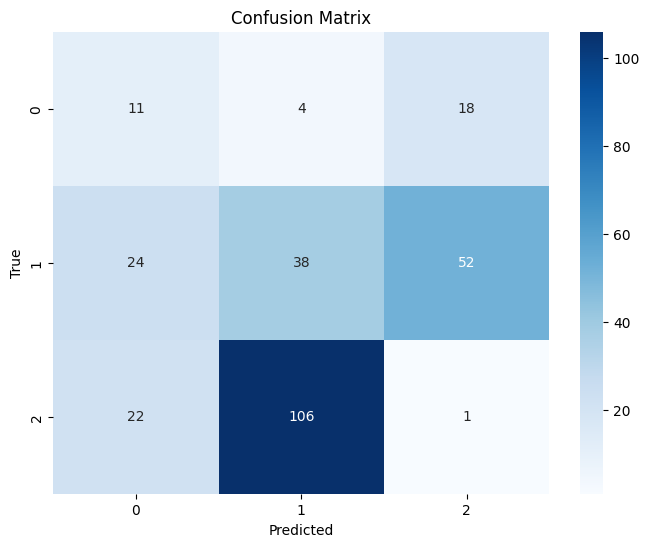

Test mAP@0.5: 0.8752, mAP@0.5:0.95: 0.4408, FPS: 7.54

image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_09_39_30_Pro.jpg: 288x512 2 class2s, 126.6ms
Speed: 2.0ms preprocess, 126.6ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 512)


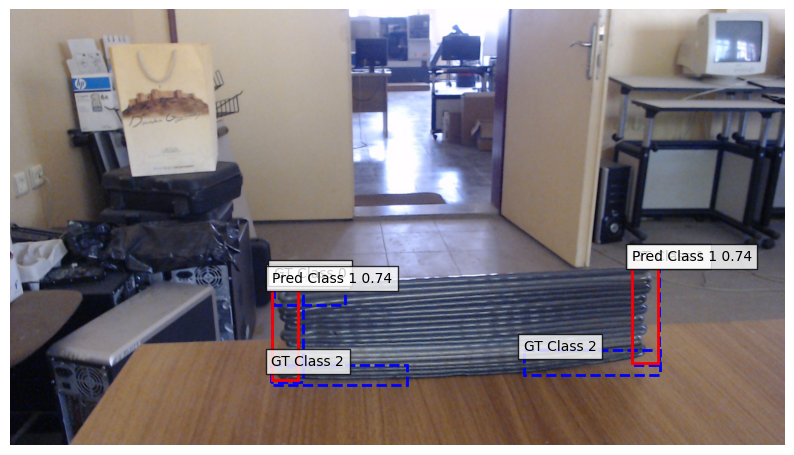


image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_10_12_35_Pro.jpg: 288x512 1 class1, 2 class2s, 151.8ms
Speed: 3.8ms preprocess, 151.8ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)


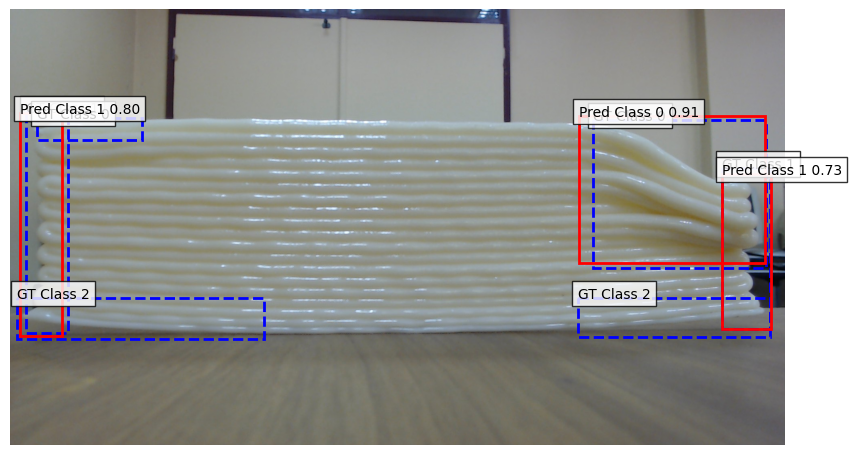


image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_09_55_49_Pro.jpg: 288x512 2 class2s, 2 class3s, 140.4ms
Speed: 3.6ms preprocess, 140.4ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 512)


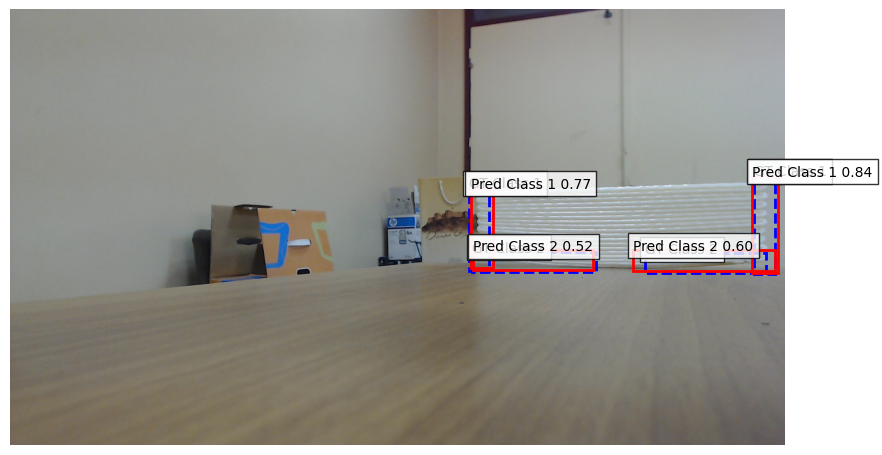

In [ ]:
# Enable inline plotting for Colab
%matplotlib inline

# Install required packages
!pip install ultralytics torch torchvision pycocotools opencv-python-headless matplotlib seaborn pandas albumentations thop

import os
import torch
from ultralytics import YOLO
from pycocotools.coco import COCO
import numpy as np
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cpu':
    print("Warning: No GPU available. Training on CPU will be slower. Ensure GPU runtime is enabled in Colab.")

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
VALID_DIR = os.path.join(BASE_PATH, 'valid')
TEST_DIR = os.path.join(BASE_PATH, 'test')
TRAIN_ANNOT = os.path.join(TRAIN_DIR, '_annotations.coco.json')
VALID_ANNOT = os.path.join(VALID_DIR, '_annotations.coco.json')
TEST_ANNOT = os.path.join(TEST_DIR, '_annotations.coco.json')

# Validate dataset paths
for path in [TRAIN_DIR, VALID_DIR, TEST_DIR, TRAIN_ANNOT, VALID_ANNOT, TEST_ANNOT]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Path does not exist: {path}")
    print(f"Path exists: {path}")

# Function to convert COCO to YOLO format
def convert_coco_to_yolo(coco_json, img_dir, output_dir):
    coco = COCO(coco_json)
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)

    for img_id in coco.getImgIds():
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info['file_name'])
        img_width, img_height = img_info['width'], img_info['height']

        output_img_path = os.path.join(output_dir, 'images', img_info['file_name'])
        if os.path.exists(img_path):
            os.system(f"cp '{img_path}' '{output_img_path}'")
        else:
            print(f"Warning: Image not found: {img_path}")
            continue

        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)
        label_path = os.path.join(output_dir, 'labels', img_info['file_name'].rsplit('.', 1)[0] + '.txt')

        with open(label_path, 'w') as f:
            for ann in annotations:
                x, y, w, h = ann['bbox']
                class_id = ann['category_id'] - 1
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                w_norm = w / img_width
                h_norm = h / img_height
                if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= w_norm <= 1 and 0 <= h_norm <= 1):
                    print(f"Warning: Invalid normalized coordinates for image ID {img_id}: {[x_center, y_center, w_norm, h_norm]}")
                    continue
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

# Convert COCO to YOLO format (comment out if already done)
TRAIN_YOLO_DIR = os.path.join(BASE_PATH, 'train_yolo')
VALID_YOLO_DIR = os.path.join(BASE_PATH, 'valid_yolo')
TEST_YOLO_DIR = os.path.join(BASE_PATH, 'test_yolo')

print("Converting COCO to YOLO format...")
convert_coco_to_yolo(TRAIN_ANNOT, TRAIN_DIR, TRAIN_YOLO_DIR)
convert_coco_to_yolo(VALID_ANNOT, VALID_DIR, VALID_YOLO_DIR)
convert_coco_to_yolo(TEST_ANNOT, TEST_DIR, TEST_YOLO_DIR)

# Create data.yaml
data_yaml_content = f"""
train: {TRAIN_YOLO_DIR}/images
val: {VALID_YOLO_DIR}/images
test: {TEST_YOLO_DIR}/images
nc: 3
names: ['class1', 'class2', 'class3']  # Replace with actual class names
"""
with open(os.path.join(BASE_PATH, 'data.yaml'), 'w') as f:
    f.write(data_yaml_content)

# Validate YOLO dataset
for split, yolo_dir in [('train', TRAIN_YOLO_DIR), ('valid', VALID_YOLO_DIR), ('test', TEST_YOLO_DIR)]:
    img_dir = os.path.join(yolo_dir, 'images')
    label_dir = os.path.join(yolo_dir, 'labels')
    if not os.path.exists(img_dir) or not os.path.exists(label_dir):
        raise FileNotFoundError(f"Missing images or labels directory in {yolo_dir}")
    print(f"{split} images: {len(os.listdir(img_dir))} files")
    print(f"{split} labels: {len(os.listdir(label_dir))} files")

# Data augmentation pipeline for training (using Albumentations)
train_transform = A.Compose([
    A.RandomResizedCrop(size=(512, 512), p=1.0),
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
    A.RandomShadow(p=0.2),
    A.CoarseDropout(num_holes=2, max_height=20, max_width=20, p=0.2),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

# Custom dataset class to apply Albumentations
class COCOYOLODataset(Dataset):
    def __init__(self, img_dir, annot_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.coco = COCO(annot_file)
        self.img_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        bboxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            bboxes.append([x, y, w, h])
            labels.append(ann['category_id'] - 1)

        if self.transform:
            augmented = self.transform(image=img, bboxes=bboxes, labels=labels)
            img = augmented['image']
            bboxes = augmented['bboxes']
            labels = augmented['labels']

        img_height, img_width = img.shape[1:3] if img.shape[0] in [1, 3] else img.shape[0:2]
        yolo_bboxes = []
        for bbox in bboxes:
            x, y, w, h = bbox
            x_center = (x + w / 2) / img_width
            y_center = (y + h / 2) / img_height
            w_norm = w / img_width
            h_norm = h / img_height
            yolo_bboxes.append([x_center, y_center, w_norm, h_norm])

        yolo_bboxes = np.array(yolo_bboxes, dtype=np.float32) if yolo_bboxes else np.zeros((0, 4), dtype=np.float32)
        labels = np.array(labels, dtype=np.int64) if labels else np.zeros((0,), dtype=np.int64)

        return {
            'img': img,
            'bboxes': torch.tensor(yolo_bboxes),
            'labels': torch.tensor(labels),
            'img_id': img_id,
            'img_path': img_path
        }

# Initialize YOLOv8 model
try:
    model = YOLO('yolov8n.pt')
    model.to(device)
except Exception as e:
    print(f"Error initializing YOLOv8 model: {e}")
    raise

# Create custom training dataset with augmentations
train_dataset_aug = COCOYOLODataset(
    img_dir=os.path.join(TRAIN_YOLO_DIR, 'images'),
    annot_file=TRAIN_ANNOT,
    transform=train_transform
)

# Create DataLoader for training
train_loader = DataLoader(
    train_dataset_aug,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    # Remove custom collate_fn and rely on default
    # collate_fn=lambda batch: {
    #     'img': torch.stack([item['img'] for item in batch]),
    #     'bboxes': [item['bboxes'] for item in batch],
    #     'labels': [item['labels'] for item in batch],
    #     'img_id': [item['img_id'] for item in batch],
    #     'img_path': [item['img_path'] for item in batch]
    # }
)

# Training with mixed precision, early stopping disabled
try:
    results = model.train(
        data=os.path.join(BASE_PATH, 'data.yaml'), # Use data.yaml for dataset paths
        epochs=50,
        imgsz=512,
        batch=8,
        device=device,
        patience=0,
        verbose=True,
        project='runs/detect',
        name='train',
        optimizer='AdamW',
        lr0=1e-4,
        cos_lr=True,
        amp=True,
        # Pass the custom DataLoader for training here, if needed for custom pipeline
        # train_loader=train_loader_aug # This is commented out as per the standard method
    )
except Exception as e:
    print(f"Error during training: {e}")
    raise

# Load training metrics from CSV
results_csv = os.path.join('runs/detect/train', 'results.csv')
metrics_df = None
if os.path.exists(results_csv):
    metrics_df = pd.read_csv(results_csv)
    if not metrics_df.empty:
        metrics_df.columns = metrics_df.columns.str.strip()
        print("Training metrics loaded from results.csv")
        print(f"Number of epochs logged: {len(metrics_df)}")
        print("Columns in results.csv:", metrics_df.columns.tolist())
    else:
        print("Training results CSV is empty.")
else:
    print(f"Training results CSV not found at {results_csv}")


# Plot loss and accuracy curves
def plot_training_metrics(metrics_df, num_epochs):
    if metrics_df is not None and not metrics_df.empty:
        num_logged_epochs = len(metrics_df)
        epochs = range(1, num_logged_epochs + 1)
        print(f"Plotting metrics for {num_logged_epochs} epochs")

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, metrics_df['train/box_loss'][:num_logged_epochs], label='Train Box Loss', color='blue')
        plt.plot(epochs, metrics_df['val/box_loss'][:num_logged_epochs], label='Val Box Loss', color='orange')
        plt.plot(epochs, metrics_df['train/cls_loss'][:num_logged_epochs], label='Train Cls Loss', color='green')
        plt.plot(epochs, metrics_df['val/cls_loss'][:num_logged_epochs], label='Val Cls Loss', color='red')
        plt.plot(epochs, metrics_df['train/dfl_loss'][:num_logged_epochs], label='Train DFL Loss', color='purple')
        plt.plot(epochs, metrics_df['val/dfl_loss'][:num_logged_epochs], label='Val DFL Loss', color='brown')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, metrics_df['metrics/precision(B)'][:num_logged_epochs], label='Precision', color='blue')
        plt.plot(epochs, metrics_df['metrics/recall(B)'][:num_logged_epochs], label='Recall', color='orange')
        plt.plot(epochs, metrics_df['metrics/mAP50(B)'][:num_logged_epochs], label='mAP@0.5', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.title('Validation Accuracy Metrics')
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Cannot plot training metrics: metrics_df is empty or not loaded.")


# Plot metrics
plot_training_metrics(metrics_df, num_epochs=50)

# Evaluation on test set
def evaluate_yolo(model, test_dir, imgsz=512):
    model.eval()
    with autocast(enabled=device.type == 'cuda'):
        results = model.val(data=os.path.join(BASE_PATH, 'data.yaml'), split='test', imgsz=imgsz, device=device)

    mAP50 = results.box.map50
    mAP = results.box.map
    print(f"Test mAP@0.5: {mAP50:.4f}, mAP@0.5:0.95: {mAP:.4f}")

    inference_times = []
    test_images = [os.path.join(test_dir, 'images', f) for f in os.listdir(os.path.join(test_dir, 'images')) if f.endswith(('.jpg', '.png'))]
    for img_path in test_images[:10]:
        start_time = time.time()
        with autocast(enabled=device.type == 'cuda'):
            model.predict(img_path, imgsz=imgsz, device=device)
        inference_times.append(time.time() - start_time)

    avg_time = sum(inference_times) / len(inference_times) if inference_times else 0
    fps = 1 / avg_time if avg_time > 0 else 0
    print(f"Average FPS: {fps:.2f}")

    true_labels = []
    pred_labels = []
    for img_path in test_images:
        label_path = os.path.join(test_dir, 'labels', os.path.basename(img_path).rsplit('.', 1)[0] + '.txt')
        img_true_labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                img_true_labels = [int(line.split()[0]) for line in f.readlines()]

        with autocast(enabled=device.type == 'cuda'):
            preds = model.predict(img_path, imgsz=imgsz, device=device, conf=0.5)
        img_pred_labels = []
        for pred in preds:
            if pred.boxes.cls is not None:
                img_pred_labels.extend(pred.boxes.cls.cpu().numpy().astype(int))

        min_len = min(len(img_true_labels), len(img_pred_labels))
        if min_len > 0:
            true_labels.extend(img_true_labels[:min_len])
            pred_labels.extend(img_pred_labels[:min_len])
        elif len(img_true_labels) > 0 and len(img_pred_labels) == 0:
            print(f"Warning: No predictions for image {os.path.basename(img_path)} with {len(img_true_labels)} ground truth labels")
        elif len(img_pred_labels) > 0 and len(img_true_labels) == 0:
            print(f"Warning: No ground truth labels for image {os.path.basename(img_path)} with {len(img_pred_labels)} predictions")

        print(f"Image {os.path.basename(img_path)}: {len(img_true_labels)} true labels, {len(img_pred_labels)} pred labels")

    if true_labels and pred_labels:
        cm = confusion_matrix(true_labels, pred_labels, labels=range(3))
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(3), yticklabels=range(3))
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    else:
        print("No valid label pairs for confusion matrix")

    return mAP50, mAP, fps

# Run evaluation
print("Evaluating on test set...")
mAP50, mAP, fps = evaluate_yolo(model, TEST_YOLO_DIR)
print(f"Test mAP@0.5: {mAP50:.4f}, mAP@0.5:0.95: {mAP:.4f}, FPS: {fps:.2f}")

# Visualize multiple predictions
def visualize_multiple_predictions_yolo(model, test_dir, num_samples=3, imgsz=512):
    model.eval()
    test_images = [os.path.join(test_dir, 'images', f) for f in os.listdir(os.path.join(test_dir, 'images')) if f.endswith(('.jpg', '.png'))]
    indices = np.random.choice(len(test_images), min(num_samples, len(test_images)), replace=False)

    for idx in indices:
        img_path = test_images[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_height, img_width = img.shape[:2]

        label_path = os.path.join(test_dir, 'labels', os.path.basename(img_path).rsplit('.', 1)[0] + '.txt')
        gt_boxes = []
        gt_labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    class_id, x_center, y_center, w, h = map(float, line.strip().split())
                    x_min = (x_center - w / 2) * img_width
                    y_min = (y_center - h / 2) * img_height
                    x_max = (x_center + w / 2) * img_width
                    y_max = (y_center + h / 2) * img_height
                    gt_boxes.append([x_min, y_min, x_max, y_max])
                    gt_labels.append(int(class_id))

        with autocast(enabled=device.type == 'cuda'):
            preds = model.predict(img_path, imgsz=imgsz, device=device, conf=0.5)

        plt.figure(figsize=(10, 10))
        plt.imshow(img)

        for box, label in zip(gt_boxes, gt_labels):
            x_min, y_min, x_max, y_max = box
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                            fill=False, color='blue', linewidth=2, linestyle='--'))
            plt.text(x_min, y_min, f'GT Class {label}',
                    bbox=dict(facecolor='white', alpha=0.8))

        for pred in preds:
            if pred.boxes.xyxy is not None:
                boxes = pred.boxes.xyxy.cpu().numpy()
                scores = pred.boxes.conf.cpu().numpy()
                labels = pred.boxes.cls.cpu().numpy().astype(int)
                for box, score, label in zip(boxes, scores, labels):
                    x_min, y_min, x_max, y_max = box
                    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                                    fill=False, color='red', linewidth=2))
                    plt.text(x_min, y_min, f'Pred Class {label} {score:.2f}',
                            bbox=dict(facecolor='white', alpha=0.8))

        plt.axis('off')
        plt.show()

# Visualize 3 samples
visualize_multiple_predictions_yolo(model, TEST_YOLO_DIR, num_samples=3)

04 - RT-DETR

05- EFFDET


conf matrix

--- Performans Metrikleri ---
Accuracy:  0.8661
Precision: 0.8385
Recall:    0.8661
F1-Score:  0.8520
ROC-AUC:   0.9140
-----------------------------


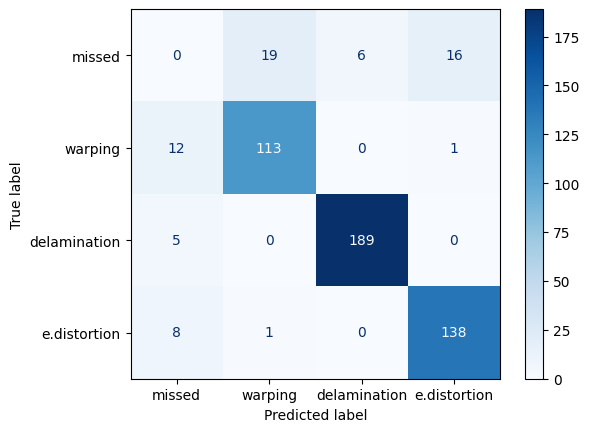

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Karışıklık matrisi verileri ve etiketleri
cm_data = np.array([
    [  0,  19,   6,  16],  # Gerçek: missed
    [ 12, 113,   0,   1],  # Gerçek: DELAMINATION
    [  5,   0, 189,   0],  # Gerçek: EDGE DISTORTION
    [  8,   1,   0, 138]   # Gerçek: WARPING
])
labels = ["missed", "warping","delamination", "e.distortion", ]
classes = list(range(len(labels))) # Sınıfları [0, 1, 2, 3] olarak alalım

# 1. Gerçek ve Tahmin Edilen Etiket Listelerini Oluşturma
# Performans metriklerini hesaplamak için bu listelere ihtiyacımız var.
# Karışıklık matrisinden bu listeleri yeniden oluşturuyoruz.
y_true = []
y_pred = []

for true_label_idx, row in enumerate(cm_data):
    for pred_label_idx, count in enumerate(row):
        # Örnek: cm[0][1] = 19 ise, 19 tane gerçek etiketi 0, tahmin etiketi 1 olan örnek vardır.
        y_true.extend([true_label_idx] * count)
        y_pred.extend([pred_label_idx] * count)

# 2. Performans Metriklerini Hesaplama
# Bu bölüm, sizin sağladığınız kodun aynısıdır.
accuracy = accuracy_score(y_true, y_pred)
# 'weighted' ortalama, her sınıfın metrik skorunu o sınıftaki eleman sayısıyla ağırlıklandırır.
# Bu, sınıf dengesizliği durumunda daha anlamlı bir sonuç verir.
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# ROC-AUC için çok sınıflı hesaplama (One-vs-Rest)
# Etiketleri ikili formata (binary format) dönüştürüyoruz.
y_true_bin = label_binarize(y_true, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)
# Not: ROC-AUC genellikle olasılık skorları üzerinden hesaplanır.
# Tahmin etiketlerini (y_pred) binarize etmek, eğrinin altında kalan alanın
# mükemmel (1.0), rastgele (0.5) veya kötü olduğu durumları basitleştirir.
roc_auc = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

# 3. Sonuçları ve Karışıklık Matrisini Gösterme

# Metrikleri yazdırma
print("--- Performans Metrikleri ---")
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {f1:.4f}')
print(f'ROC-AUC:   {roc_auc:.4f}')
print("-----------------------------")

# Karışıklık Matrisini Çizme
disp = ConfusionMatrixDisplay(confusion_matrix=cm_data, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
#plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- Performans Metrikleri ---
Accuracy:  0.0000
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.3181
-----------------------------


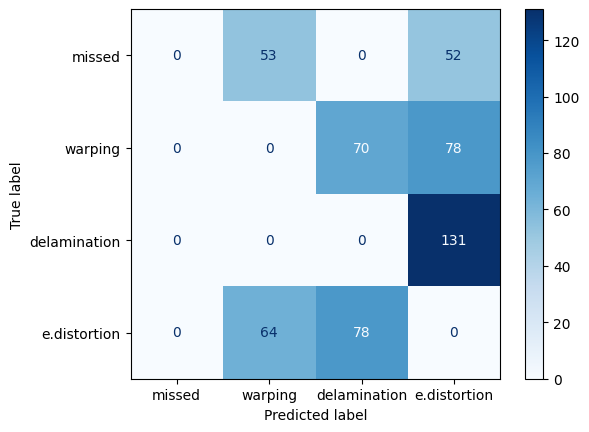

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

# Karışıklık matrisi verileri ve etiketleri
cm_data = np.array([
    [  0,  53,   0,  52],  # Gerçek: missed
    [ 0, 0,   70,   78],  # Gerçek: DELAMINATION
    [  0,   0, 0,   131],  # Gerçek: EDGE DISTORTION
    [  0,   64,   78, 0]   # Gerçek: WARPING
])
labels = ["missed", "warping","delamination", "e.distortion", ]
classes = list(range(len(labels))) # Sınıfları [0, 1, 2, 3] olarak alalım

# 1. Gerçek ve Tahmin Edilen Etiket Listelerini Oluşturma
# Performans metriklerini hesaplamak için bu listelere ihtiyacımız var.
# Karışıklık matrisinden bu listeleri yeniden oluşturuyoruz.
y_true = []
y_pred = []

for true_label_idx, row in enumerate(cm_data):
    for pred_label_idx, count in enumerate(row):
        # Örnek: cm[0][1] = 19 ise, 19 tane gerçek etiketi 0, tahmin etiketi 1 olan örnek vardır.
        y_true.extend([true_label_idx] * count)
        y_pred.extend([pred_label_idx] * count)

# 2. Performans Metriklerini Hesaplama
# Bu bölüm, sizin sağladığınız kodun aynısıdır.
accuracy = accuracy_score(y_true, y_pred)
# 'weighted' ortalama, her sınıfın metrik skorunu o sınıftaki eleman sayısıyla ağırlıklandırır.
# Bu, sınıf dengesizliği durumunda daha anlamlı bir sonuç verir.
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# ROC-AUC için çok sınıflı hesaplama (One-vs-Rest)
# Etiketleri ikili formata (binary format) dönüştürüyoruz.
y_true_bin = label_binarize(y_true, classes=classes)
y_pred_bin = label_binarize(y_pred, classes=classes)
# Not: ROC-AUC genellikle olasılık skorları üzerinden hesaplanır.
# Tahmin etiketlerini (y_pred) binarize etmek, eğrinin altında kalan alanın
# mükemmel (1.0), rastgele (0.5) veya kötü olduğu durumları basitleştirir.
roc_auc = roc_auc_score(y_true_bin, y_pred_bin, average='weighted', multi_class='ovr')

# 3. Sonuçları ve Karışıklık Matrisini Gösterme

# Metrikleri yazdırma
print("--- Performans Metrikleri ---")
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-Score:  {f1:.4f}')
print(f'ROC-AUC:   {roc_auc:.4f}')
print("-----------------------------")

# Karışıklık Matrisini Çizme
disp = ConfusionMatrixDisplay(confusion_matrix=cm_data, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
#plt.title("Confusion Matrix")
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


/tmp/ipython-input-3723811210.py:125: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
/tmp/ipython-input-3723811210.py:127: UserWarning: Argument(s) 'num_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(num_holes=2, max_height=20, max_width=20, p=0.2),


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=0, perspective=0.

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

 22        [15, 18, 21]  1    751897  ultralytics.nn.modules.head.Detect           [3, [64, 128, 256]]           
Model summary: 129 layers, 3,011,433 parameters, 3,011,417 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.4±0.1 ms, read: 69.8±15.3 MB/s, size: 223.8 KB)


train: Scanning /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/train_yolo/labels.cache... 511 images, 0 backgrounds, 0 corrupt: 100%|██████████| 511/511 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 2.0±3.2 ms, read: 45.5±39.4 MB/s, size: 236.4 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/valid_yolo/labels.cache... 146 images, 0 backgrounds, 0 corrupt: 100%|██████████| 146/146 [00:00<?, ?it/s]

Plotting labels to runs/detect/train/labels.jpg... 


optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      2.306      3.041      1.588         71        512: 100%|██████████| 64/64 [04:31<00:00,  4.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]

                   all        146        754     0.0175       0.74      0.233      0.075



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      2.032      2.117      1.415         60        512: 100%|██████████| 64/64 [04:25<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]

                   all        146        754      0.448      0.354      0.433      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.974       1.79      1.372         71        512: 100%|██████████| 64/64 [04:29<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

                   all        146        754      0.564      0.598      0.558      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.939      1.637       1.31         67        512: 100%|██████████| 64/64 [04:24<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]

                   all        146        754      0.631      0.617      0.609      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.916       1.55      1.311         70        512: 100%|██████████| 64/64 [04:29<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

                   all        146        754      0.701      0.644      0.662      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.859      1.493      1.293         63        512: 100%|██████████| 64/64 [04:23<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]

                   all        146        754      0.741      0.657      0.695       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.817      1.415      1.257         57        512: 100%|██████████| 64/64 [04:23<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        146        754      0.719      0.688      0.697       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.806      1.387      1.247         69        512: 100%|██████████| 64/64 [04:25<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.83s/it]

                   all        146        754       0.78      0.695      0.724      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      1.793      1.349      1.226         83        512: 100%|██████████| 64/64 [04:27<00:00,  4.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]

                   all        146        754      0.745       0.71      0.727      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.783      1.315      1.233         55        512: 100%|██████████| 64/64 [04:25<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        146        754      0.791      0.725      0.754      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.764      1.292      1.218         55        512: 100%|██████████| 64/64 [04:24<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]

                   all        146        754      0.771      0.736      0.773      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.742      1.263      1.204         77        512: 100%|██████████| 64/64 [04:24<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]

                   all        146        754      0.802      0.743      0.788       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.749      1.253      1.215         68        512: 100%|██████████| 64/64 [04:24<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

                   all        146        754      0.799      0.755      0.803      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.724      1.238      1.201         76        512: 100%|██████████| 64/64 [04:25<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]

                   all        146        754      0.822      0.751      0.805      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.718      1.213      1.185         73        512: 100%|██████████| 64/64 [04:24<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        146        754      0.773       0.77      0.808      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.738      1.198      1.185         69        512: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.90s/it]

                   all        146        754      0.796      0.781      0.815      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.702      1.185       1.18         47        512: 100%|██████████| 64/64 [04:25<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]

                   all        146        754      0.823      0.774      0.825      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.697      1.162      1.188         65        512: 100%|██████████| 64/64 [04:28<00:00,  4.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        146        754      0.828      0.791      0.828      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.676      1.147       1.18         68        512: 100%|██████████| 64/64 [04:25<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]

                   all        146        754      0.798      0.804      0.835      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.677      1.144      1.162         95        512: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        146        754      0.852      0.801      0.859      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.658      1.146      1.169         73        512: 100%|██████████| 64/64 [04:25<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.84s/it]

                   all        146        754      0.847      0.794      0.859      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.691      1.132      1.167         94        512: 100%|██████████| 64/64 [04:24<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        146        754      0.827      0.825      0.855      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.656       1.12      1.159         85        512: 100%|██████████| 64/64 [04:26<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        146        754      0.846       0.83      0.867      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G      1.686      1.126      1.179         56        512: 100%|██████████| 64/64 [04:29<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

                   all        146        754      0.849      0.807      0.862      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.656      1.108      1.153         67        512: 100%|██████████| 64/64 [04:26<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        146        754      0.848      0.835       0.88      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.677      1.107      1.158         88        512: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]

                   all        146        754      0.845      0.823      0.878      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.678      1.084      1.152         87        512: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        146        754      0.854       0.83      0.888      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.646      1.092      1.161         71        512: 100%|██████████| 64/64 [04:25<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.80s/it]

                   all        146        754      0.845      0.859      0.885       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.629      1.091       1.15         99        512: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

                   all        146        754      0.847       0.84      0.885       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G      1.635      1.083      1.147         68        512: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

                   all        146        754      0.844      0.845      0.887      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.612      1.064      1.139         36        512: 100%|██████████| 64/64 [04:24<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]

                   all        146        754      0.852      0.851      0.894      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.632      1.073      1.138         76        512: 100%|██████████| 64/64 [04:24<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        146        754      0.864       0.84      0.896      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.634      1.068      1.144         60        512: 100%|██████████| 64/64 [04:25<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]

                   all        146        754      0.867       0.85      0.901      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.635      1.073      1.149         45        512: 100%|██████████| 64/64 [04:53<00:00,  4.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.88s/it]

                   all        146        754      0.876      0.853        0.9      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.622      1.051      1.146         62        512: 100%|██████████| 64/64 [07:32<00:00,  7.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]

                   all        146        754      0.876      0.837      0.893      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.624      1.051      1.145         79        512: 100%|██████████| 64/64 [09:18<00:00,  8.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [02:11<00:00, 13.15s/it]

                   all        146        754      0.866      0.854      0.905      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G       1.62      1.059      1.157         89        512: 100%|██████████| 64/64 [06:51<00:00,  6.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:21<00:00,  8.14s/it]

                   all        146        754      0.858      0.861      0.901      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.631      1.068      1.155         80        512: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]

                   all        146        754      0.865      0.861      0.904      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.598      1.053      1.143         63        512: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

                   all        146        754      0.879      0.847      0.904      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.604      1.036       1.13         66        512: 100%|██████████| 64/64 [04:25<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        146        754      0.892      0.841      0.908      0.434


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.617      1.165      1.189         39        512: 100%|██████████| 64/64 [04:21<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.79s/it]

                   all        146        754      0.858      0.855      0.891      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G       1.61      1.107      1.179         33        512: 100%|██████████| 64/64 [04:24<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.89s/it]

                   all        146        754      0.852       0.84      0.886      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.598      1.095       1.18         38        512: 100%|██████████| 64/64 [04:23<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

                   all        146        754      0.858      0.835      0.883      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.604       1.09      1.166         40        512: 100%|██████████| 64/64 [04:23<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.90s/it]

                   all        146        754      0.882      0.836      0.889      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G       1.58      1.075      1.169         34        512: 100%|██████████| 64/64 [04:23<00:00,  4.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]

                   all        146        754       0.88      0.837      0.894      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.594      1.075      1.186         37        512: 100%|██████████| 64/64 [04:22<00:00,  4.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]

                   all        146        754      0.881      0.845      0.898      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.585      1.071      1.168         39        512: 100%|██████████| 64/64 [04:23<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.81s/it]

                   all        146        754      0.878      0.854      0.902      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.585      1.063      1.157         40        512: 100%|██████████| 64/64 [04:23<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]

                   all        146        754      0.865      0.853      0.899      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.576      1.064      1.156         43        512: 100%|██████████| 64/64 [04:23<00:00,  4.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]

                   all        146        754      0.862      0.856      0.898      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.576      1.062      1.165         30        512: 100%|██████████| 64/64 [04:23<00:00,  4.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]

                   all        146        754       0.87      0.857      0.901      0.427



50 epochs completed in 4.173 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:17<00:00,  1.72s/it]


                   all        146        754      0.891      0.841      0.908      0.435
                class1         92        196      0.861      0.666      0.817      0.356
                class2        144        288      0.971      0.993      0.991      0.566
                class3        135        270      0.841      0.863      0.917      0.381
Speed: 0.9ms preprocess, 90.1ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train
Training metrics loaded from results.csv
Number of epochs logged: 50
Columns in results.csv: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']
Plotting metrics for 50 epochs


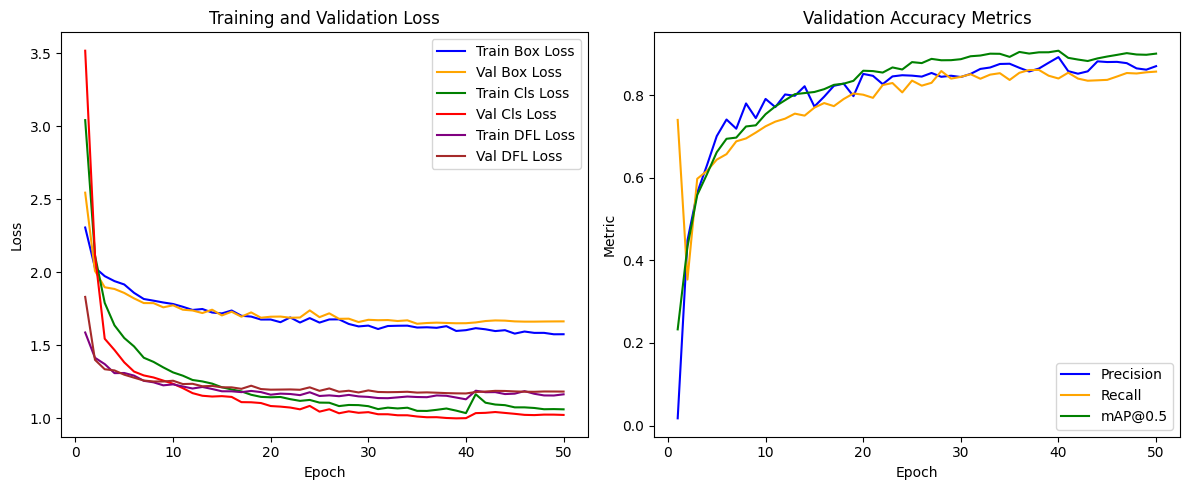

Evaluating on test set...
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.5±0.2 ms, read: 0.4±0.1 MB/s, size: 201.3 KB)


val: Scanning /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/labels.cache... 74 images, 0 backgrounds, 0 corrupt: 100%|██████████| 74/74 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


                   all         74        384      0.862      0.836      0.875      0.441
                class1         53        105      0.773      0.638      0.754      0.366
                class2         74        148      0.995          1      0.995       0.57
                class3         66        131      0.818       0.87      0.876      0.386
Speed: 0.7ms preprocess, 88.8ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/train2
Test mAP@0.5: 0.8752, mAP@0.5:0.95: 0.4408

image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_10_08_53_Pro.jpg: 288x512 2 class2s, 2 class3s, 87.8ms
Speed: 2.1ms preprocess, 87.8ms inference, 8.3ms postprocess per image at shape (1, 3, 288, 512)

image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_09_42_18_Pro.jpg: 288x512 2 class2s, 2 class3s, 83.7ms
Speed: 2.1ms preprocess, 83.7ms inference, 1.1ms postprocess per image at shape

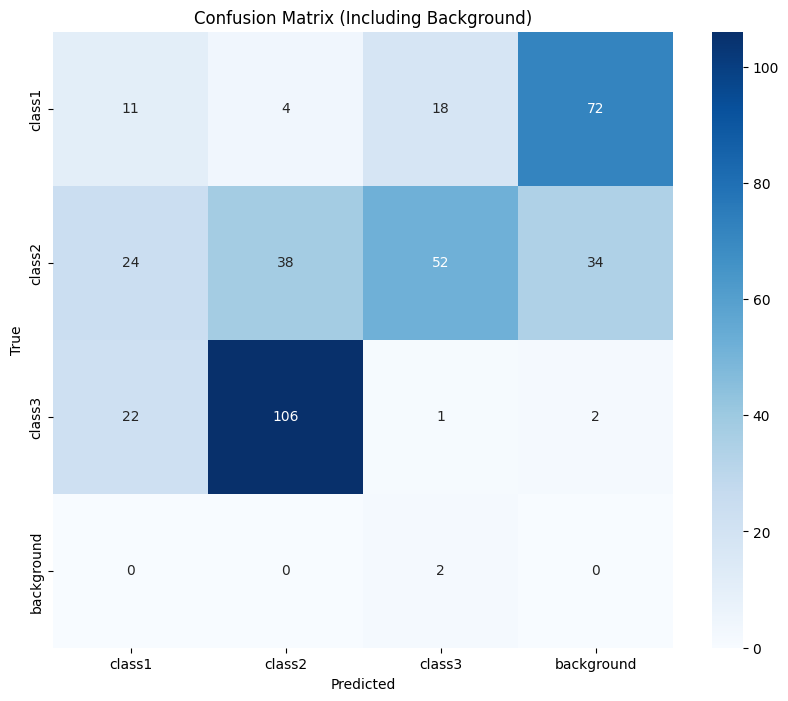

Test mAP@0.5: 0.8752, mAP@0.5:0.95: 0.4408, FPS: 6.65

image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_09_42_18_Pro.jpg: 288x512 2 class2s, 1 class3, 121.1ms
Speed: 3.1ms preprocess, 121.1ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 512)


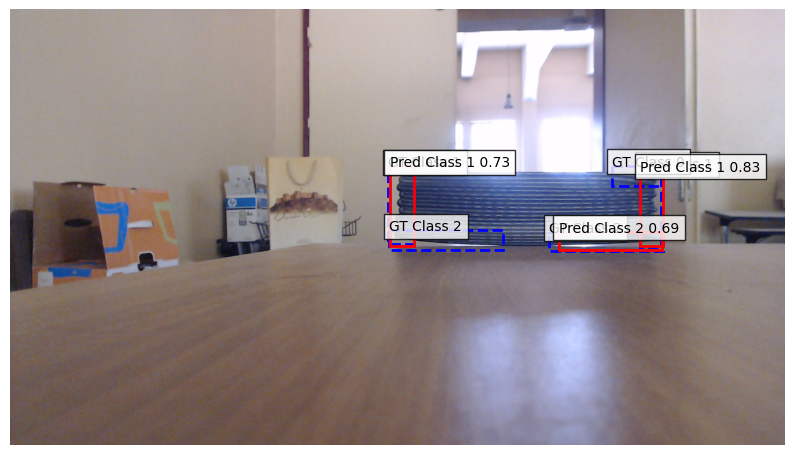


image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_10_12_35_Pro.jpg: 288x512 1 class1, 2 class2s, 109.5ms
Speed: 3.0ms preprocess, 109.5ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 512)


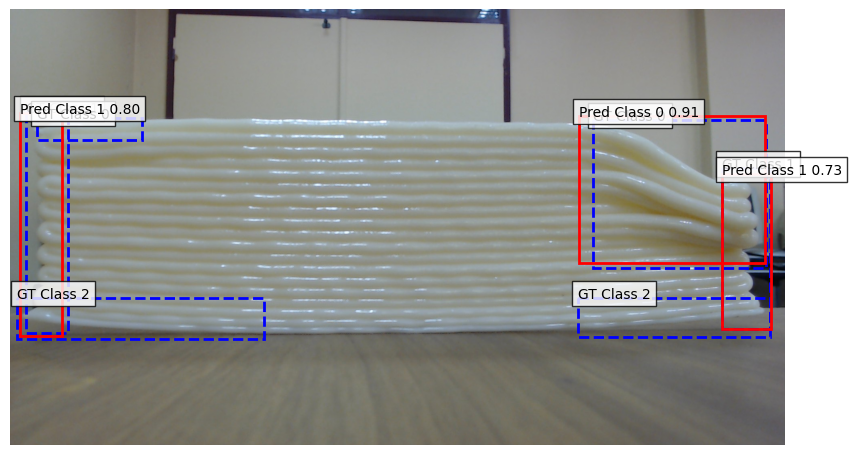


image 1/1 /content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s/test_yolo/images/WIN_20250730_09_51_02_Pro.jpg: 288x512 2 class1s, 2 class2s, 2 class3s, 125.8ms
Speed: 3.1ms preprocess, 125.8ms inference, 1.0ms postprocess per image at shape (1, 3, 288, 512)


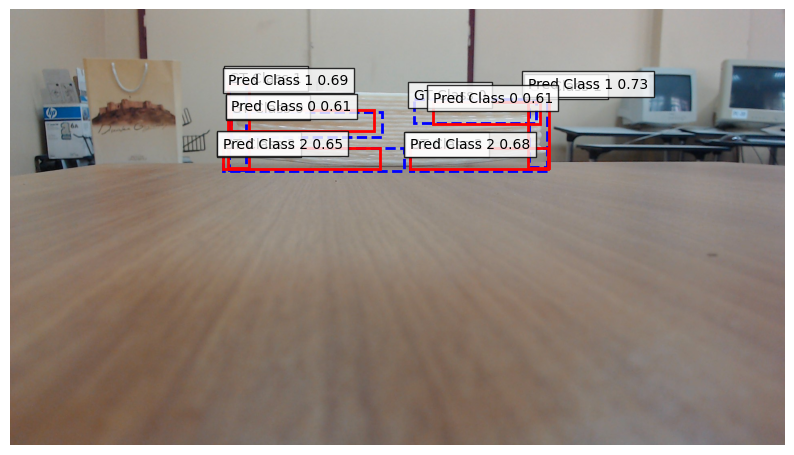

In [ ]:
# Enable inline plotting for Colab
%matplotlib inline

# Install required packages
!pip install ultralytics torch torchvision pycocotools opencv-python-headless matplotlib seaborn pandas albumentations thop

import os
import torch
from ultralytics import YOLO
from pycocotools.coco import COCO
import numpy as np
from google.colab import drive
import cv2
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cpu':
    print("Warning: No GPU available. Training on CPU will be slower. Ensure GPU runtime is enabled in Colab.")

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/dataset-1-10_01_s'
TRAIN_DIR = os.path.join(BASE_PATH, 'train')
VALID_DIR = os.path.join(BASE_PATH, 'valid')
TEST_DIR = os.path.join(BASE_PATH, 'test')
TRAIN_ANNOT = os.path.join(TRAIN_DIR, '_annotations.coco.json')
VALID_ANNOT = os.path.join(VALID_DIR, '_annotations.coco.json')
TEST_ANNOT = os.path.join(TEST_DIR, '_annotations.coco.json')

# Validate dataset paths
for path in [TRAIN_DIR, VALID_DIR, TEST_DIR, TRAIN_ANNOT, VALID_ANNOT, TEST_ANNOT]:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Path does not exist: {path}")
    print(f"Path exists: {path}")

# Function to convert COCO to YOLO format
def convert_coco_to_yolo(coco_json, img_dir, output_dir):
    coco = COCO(coco_json)
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)

    for img_id in coco.getImgIds():
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(img_dir, img_info['file_name'])
        img_width, img_height = img_info['width'], img_info['height']

        output_img_path = os.path.join(output_dir, 'images', img_info['file_name'])
        if os.path.exists(img_path):
            os.system(f"cp '{img_path}' '{output_img_path}'")
        else:
            print(f"Warning: Image not found: {img_path}")
            continue

        ann_ids = coco.getAnnIds(imgIds=img_id)
        annotations = coco.loadAnns(ann_ids)
        label_path = os.path.join(output_dir, 'labels', img_info['file_name'].rsplit('.', 1)[0] + '.txt')

        with open(label_path, 'w') as f:
            for ann in annotations:
                x, y, w, h = ann['bbox']
                class_id = ann['category_id'] - 1
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                w_norm = w / img_width
                h_norm = h / img_height
                if not (0 <= x_center <= 1 and 0 <= y_center <= 1 and 0 <= w_norm <= 1 and 0 <= h_norm <= 1):
                    print(f"Warning: Invalid normalized coordinates for image ID {img_id}: {[x_center, y_center, w_norm, h_norm]}")
                    continue
                f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

# Convert COCO to YOLO format (comment out if already done)
TRAIN_YOLO_DIR = os.path.join(BASE_PATH, 'train_yolo')
VALID_YOLO_DIR = os.path.join(BASE_PATH, 'valid_yolo')
TEST_YOLO_DIR = os.path.join(BASE_PATH, 'test_yolo')

print("Converting COCO to YOLO format...")
convert_coco_to_yolo(TRAIN_ANNOT, TRAIN_DIR, TRAIN_YOLO_DIR)
convert_coco_to_yolo(VALID_ANNOT, VALID_DIR, VALID_YOLO_DIR)
convert_coco_to_yolo(TEST_ANNOT, TEST_DIR, TEST_YOLO_DIR)

# Create data.yaml
data_yaml_content = f"""
train: {TRAIN_YOLO_DIR}/images
val: {VALID_YOLO_DIR}/images
test: {TEST_YOLO_DIR}/images
nc: 3
names: ['class1', 'class2', 'class3']  # Replace with actual class names
"""
with open(os.path.join(BASE_PATH, 'data.yaml'), 'w') as f:
    f.write(data_yaml_content)

# Validate YOLO dataset
for split, yolo_dir in [('train', TRAIN_YOLO_DIR), ('valid', VALID_YOLO_DIR), ('test', TEST_YOLO_DIR)]:
    img_dir = os.path.join(yolo_dir, 'images')
    label_dir = os.path.join(yolo_dir, 'labels')
    if not os.path.exists(img_dir) or not os.path.exists(label_dir):
        raise FileNotFoundError(f"Missing images or labels directory in {yolo_dir}")
    print(f"{split} images: {len(os.listdir(img_dir))} files")
    print(f"{split} labels: {len(os.listdir(label_dir))} files")

# Data augmentation pipeline for training (using Albumentations)
train_transform = A.Compose([
    A.RandomResizedCrop(size=(512, 512), p=1.0),
    A.HorizontalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.3),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.2),
    A.RandomShadow(p=0.2),
    A.CoarseDropout(num_holes=2, max_height=20, max_width=20, p=0.2),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='coco', label_fields=['labels']))

# Custom dataset class to apply Albumentations
class COCOYOLODataset(Dataset):
    def __init__(self, img_dir, annot_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.coco = COCO(annot_file)
        self.img_ids = self.coco.getImgIds()

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        bboxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            bboxes.append([x, y, w, h])
            labels.append(ann['category_id'] - 1)

        if self.transform:
            augmented = self.transform(image=img, bboxes=bboxes, labels=labels)
            img = augmented['image']
            bboxes = augmented['bboxes']
            labels = augmented['labels']

        img_height, img_width = img.shape[1:3] if img.shape[0] in [1, 3] else img.shape[0:2]
        yolo_bboxes = []
        for bbox in bboxes:
            x, y, w, h = bbox
            x_center = (x + w / 2) / img_width
            y_center = (y + h / 2) / img_height
            w_norm = w / img_width
            h_norm = h / img_height
            yolo_bboxes.append([x_center, y_center, w_norm, h_norm])

        yolo_bboxes = np.array(yolo_bboxes, dtype=np.float32) if yolo_bboxes else np.zeros((0, 4), dtype=np.float32)
        labels = np.array(labels, dtype=np.int64) if labels else np.zeros((0,), dtype=np.int64)

        return {
            'img': img,
            'bboxes': torch.tensor(yolo_bboxes),
            'labels': torch.tensor(labels),
            'img_id': img_id,
            'img_path': img_path
        }

# Initialize YOLOv8 model
try:
    model = YOLO('yolov8n.pt')
    model.to(device)
except Exception as e:
    print(f"Error initializing YOLOv8 model: {e}")
    raise

# Create custom training dataset with augmentations
train_dataset_aug = COCOYOLODataset(
    img_dir=os.path.join(TRAIN_YOLO_DIR, 'images'),
    annot_file=TRAIN_ANNOT,
    transform=train_transform
)

# Create DataLoader for training
train_loader = DataLoader(
    train_dataset_aug,
    batch_size=8,
    shuffle=True,
    num_workers=2,
)

# Training with mixed precision, early stopping disabled
try:
    results = model.train(
        data=os.path.join(BASE_PATH, 'data.yaml'),
        epochs=50,
        imgsz=512,
        batch=8,
        device=device,
        patience=0,
        verbose=True,
        project='runs/detect',
        name='train',
        optimizer='AdamW',
        lr0=1e-4,
        cos_lr=True,
        amp=True,
    )
except Exception as e:
    print(f"Error during training: {e}")
    raise

# Load training metrics from CSV
results_csv = os.path.join('runs/detect/train', 'results.csv')
metrics_df = None
if os.path.exists(results_csv):
    metrics_df = pd.read_csv(results_csv)
    if not metrics_df.empty:
        metrics_df.columns = metrics_df.columns.str.strip()
        print("Training metrics loaded from results.csv")
        print(f"Number of epochs logged: {len(metrics_df)}")
        print("Columns in results.csv:", metrics_df.columns.tolist())
    else:
        print("Training results CSV is empty.")
else:
    print(f"Training results CSV not found at {results_csv}")

# Plot loss and accuracy curves
def plot_training_metrics(metrics_df, num_epochs):
    if metrics_df is not None and not metrics_df.empty:
        num_logged_epochs = len(metrics_df)
        epochs = range(1, num_logged_epochs + 1)
        print(f"Plotting metrics for {num_logged_epochs} epochs")

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, metrics_df['train/box_loss'][:num_logged_epochs], label='Train Box Loss', color='blue')
        plt.plot(epochs, metrics_df['val/box_loss'][:num_logged_epochs], label='Val Box Loss', color='orange')
        plt.plot(epochs, metrics_df['train/cls_loss'][:num_logged_epochs], label='Train Cls Loss', color='green')
        plt.plot(epochs, metrics_df['val/cls_loss'][:num_logged_epochs], label='Val Cls Loss', color='red')
        plt.plot(epochs, metrics_df['train/dfl_loss'][:num_logged_epochs], label='Train DFL Loss', color='purple')
        plt.plot(epochs, metrics_df['val/dfl_loss'][:num_logged_epochs], label='Val DFL Loss', color='brown')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, metrics_df['metrics/precision(B)'][:num_logged_epochs], label='Precision', color='blue')
        plt.plot(epochs, metrics_df['metrics/recall(B)'][:num_logged_epochs], label='Recall', color='orange')
        plt.plot(epochs, metrics_df['metrics/mAP50(B)'][:num_logged_epochs], label='mAP@0.5', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('Metric')
        plt.title('Validation Accuracy Metrics')
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("Cannot plot training metrics: metrics_df is empty or not loaded.")

# Plot metrics
plot_training_metrics(metrics_df, num_epochs=50)

# Evaluation on test set with background class in confusion matrix
def evaluate_yolo(model, test_dir, imgsz=512):
    model.eval()
    with autocast(enabled=device.type == 'cuda'):
        results = model.val(data=os.path.join(BASE_PATH, 'data.yaml'), split='test', imgsz=imgsz, device=device)

    mAP50 = results.box.map50
    mAP = results.box.map
    print(f"Test mAP@0.5: {mAP50:.4f}, mAP@0.5:0.95: {mAP:.4f}")

    inference_times = []
    test_images = [os.path.join(test_dir, 'images', f) for f in os.listdir(os.path.join(test_dir, 'images')) if f.endswith(('.jpg', '.png'))]
    for img_path in test_images[:10]:
        start_time = time.time()
        with autocast(enabled=device.type == 'cuda'):
            model.predict(img_path, imgsz=imgsz, device=device)
        inference_times.append(time.time() - start_time)

    avg_time = sum(inference_times) / len(inference_times) if inference_times else 0
    fps = 1 / avg_time if avg_time > 0 else 0
    print(f"Average FPS: {fps:.2f}")

    true_labels = []
    pred_labels = []
    num_classes = 3  # Number of object classes
    background_class = num_classes  # Background class index (3)

    for img_path in test_images:
        label_path = os.path.join(test_dir, 'labels', os.path.basename(img_path).rsplit('.', 1)[0] + '.txt')
        img_true_labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                img_true_labels = [int(line.split()[0]) for line in f.readlines()]

        with autocast(enabled=device.type == 'cuda'):
            preds = model.predict(img_path, imgsz=imgsz, device=device, conf=0.5)
        img_pred_labels = []
        for pred in preds:
            if pred.boxes.cls is not None:
                img_pred_labels.extend(pred.boxes.cls.cpu().numpy().astype(int))

        # Handle background class
        if len(img_true_labels) == 0 and len(img_pred_labels) == 0:
            # Both ground truth and prediction agree on background
            true_labels.append(background_class)
            pred_labels.append(background_class)
        elif len(img_true_labels) > 0 and len(img_pred_labels) == 0:
            # Ground truth has objects, but model predicts none (background)
            true_labels.extend(img_true_labels)
            pred_labels.extend([background_class] * len(img_true_labels))
        elif len(img_true_labels) == 0 and len(img_pred_labels) > 0:
            # Ground truth is background, but model predicts objects
            true_labels.extend([background_class] * len(img_pred_labels))
            pred_labels.extend(img_pred_labels)
        else:
            # Both have detections, align them
            min_len = min(len(img_true_labels), len(img_pred_labels))
            if min_len > 0:
                true_labels.extend(img_true_labels[:min_len])
                pred_labels.extend(img_pred_labels[:min_len])
            # Handle remaining ground truth as missed detections (background)
            if len(img_true_labels) > min_len:
                true_labels.extend(img_true_labels[min_len:])
                pred_labels.extend([background_class] * (len(img_true_labels) - min_len))
            # Handle remaining predictions as false positives
            if len(img_pred_labels) > min_len:
                true_labels.extend([background_class] * (len(img_pred_labels) - min_len))
                pred_labels.extend(img_pred_labels[min_len:])

        print(f"Image {os.path.basename(img_path)}: {len(img_true_labels)} true labels, {len(img_pred_labels)} pred labels")

    if true_labels and pred_labels:
        # Create confusion matrix including background class
        class_names = ['class1', 'class2', 'class3', 'background']  # Replace with actual class names
        cm = confusion_matrix(true_labels, pred_labels, labels=range(num_classes + 1))
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix (Including Background)')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
    else:
        print("No valid label pairs for confusion matrix")

    return mAP50, mAP, fps

# Run evaluation
print("Evaluating on test set...")
mAP50, mAP, fps = evaluate_yolo(model, TEST_YOLO_DIR)
print(f"Test mAP@0.5: {mAP50:.4f}, mAP@0.5:0.95: {mAP:.4f}, FPS: {fps:.2f}")

# Visualize multiple predictions
def visualize_multiple_predictions_yolo(model, test_dir, num_samples=3, imgsz=512):
    model.eval()
    test_images = [os.path.join(test_dir, 'images', f) for f in os.listdir(os.path.join(test_dir, 'images')) if f.endswith(('.jpg', '.png'))]
    indices = np.random.choice(len(test_images), min(num_samples, len(test_images)), replace=False)

    for idx in indices:
        img_path = test_images[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_height, img_width = img.shape[:2]

        label_path = os.path.join(test_dir, 'labels', os.path.basename(img_path).rsplit('.', 1)[0] + '.txt')
        gt_boxes = []
        gt_labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    class_id, x_center, y_center, w, h = map(float, line.strip().split())
                    x_min = (x_center - w / 2) * img_width
                    y_min = (y_center - h / 2) * img_height
                    x_max = (x_center + w / 2) * img_width
                    y_max = (y_center + h / 2) * img_height
                    gt_boxes.append([x_min, y_min, x_max, y_max])
                    gt_labels.append(int(class_id))

        with autocast(enabled=device.type == 'cuda'):
            preds = model.predict(img_path, imgsz=imgsz, device=device, conf=0.5)

        plt.figure(figsize=(10, 10))
        plt.imshow(img)

        for box, label in zip(gt_boxes, gt_labels):
            x_min, y_min, x_max, y_max = box
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                            fill=False, color='blue', linewidth=2, linestyle='--'))
            plt.text(x_min, y_min, f'GT Class {label}',
                    bbox=dict(facecolor='white', alpha=0.8))

        for pred in preds:
            if pred.boxes.xyxy is not None:
                boxes = pred.boxes.xyxy.cpu().numpy()
                scores = pred.boxes.conf.cpu().numpy()
                labels = pred.boxes.cls.cpu().numpy().astype(int)
                for box, score, label in zip(boxes, scores, labels):
                    x_min, y_min, x_max, y_max = box
                    plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                                    fill=False, color='red', linewidth=2))
                    plt.text(x_min, y_min, f'Pred Class {label} {score:.2f}',
                            bbox=dict(facecolor='white', alpha=0.8))

        plt.axis('off')
        plt.show()

# Visualize 3 samples
visualize_multiple_predictions_yolo(model, TEST_YOLO_DIR, num_samples=3)



